In [20]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot
import csv

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
#from lib.lib_ot import *
from lib.lib_lopt import *
from lib.geodesic import *
from lib.tools import *

In [21]:
def row_to_numpy(row):
    data={}
    row2=row.copy()
    data['label']=row2['label']
    del row2['label']
    N=len(row2)
    np_array=np.array(list(row2.values()),dtype=np.float64)
    np_array=np_array.reshape((int(np_array.shape[0]/3),3))
    X=np_array[:,[0,1]]
    p=np_array[:,2]
    D=p>0
    X_take=X[D]
    p_take=p[D]
    data['X']=X_take
    data['p']=p_take
    return data

In [22]:
#load and convert data into numpy array
with open('experiment/data/MNIST/train.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    data_list=list()
    for row in reader:
        data=row_to_numpy(row)
        data_list.append(data)

torch.save(data_list,'experiment/data/MNIST_list.pt')

# with open('experiment/data/MNIST/test.csv', newline='') as csvfile:
#     reader = csv.DictReader(csvfile)
#     data_list=list()
#     for row in reader:
#         data=row_to_numpy(row)
#         data_list.append(data)

# torch.save(data_list,'experiment/data/MNIST/test_list.pt')



In [23]:
# generate the data for geodesic experiment 

i1=1 #label=0
i2=3 #labal=1
i3=4 #labal=6
MNIST_list=torch.load('experiment/data/MNIST_list.pt')
X1=MNIST_list[i1]['X']
p1=MNIST_list[i1]['p']
p1=p1/np.sum(p1)

X2=MNIST_list[i2]['X']
p2=MNIST_list[i2]['p']
p2=p2/np.sum(p2)

X3=MNIST_list[i3]['X']
p3=MNIST_list[i3]['p']
p3=p3/np.sum(p3)
data={}

data['data_0']=[[X1,X2,X3],[p1,p2,p3]]
torch.save(data,'experiment/geodesic/data/MNIST_019.pt')


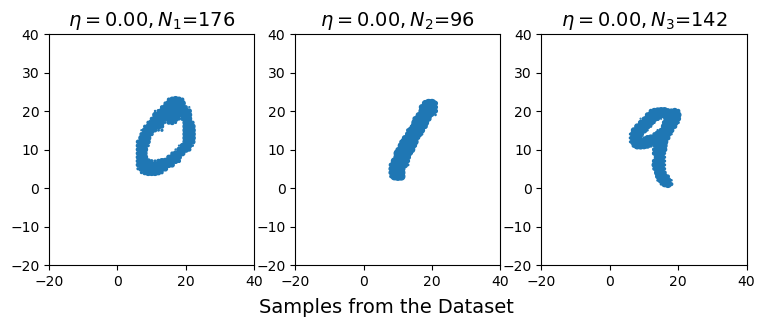

done


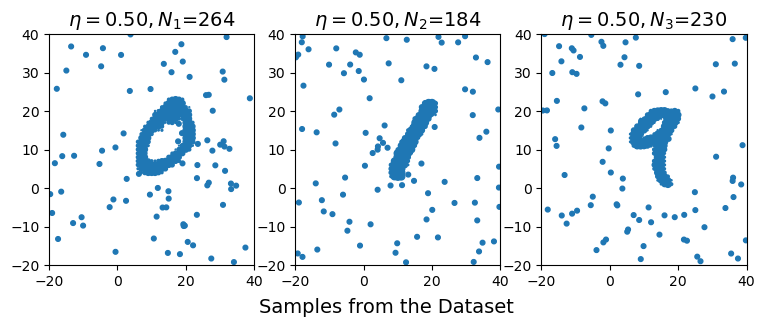

done


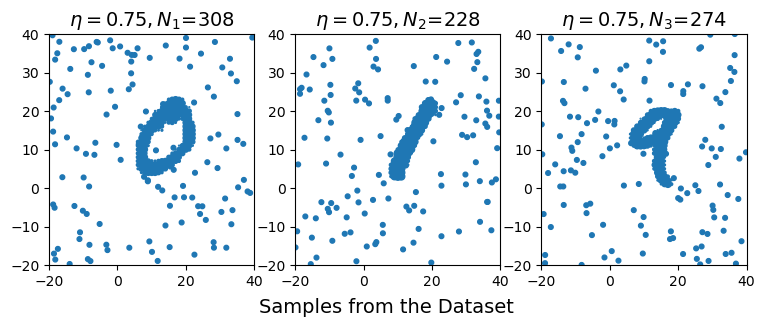

done


In [30]:
# generate data for geodesic experiment 
#add noise to clean data. 
data_list=torch.load('experiment/geodesic/data/MNIST_019.pt')
X,p=data_list['data_0']
N,d=X[0].shape
M=len(X)
for eta in [0.5,0.75]:
    X_noise=list()
    p_noise=list()
    n_noise=int(N*eta)
    for i in range(M):
        Xi=X[i]
        pi=p[i]
        noise_i=np.random.uniform(low=[-20,-20],high=[40,40],size=(n_noise,2))
        X_hat_i=np.concatenate((Xi,noise_i))
        X_noise.append(X_hat_i)
        pi_noise=np.concatenate((pi,np.ones(n_noise)/n_noise*eta))
        p_noise.append(pi_noise)
       
        
    data_list['data_'+str(eta)]=(X_noise,p_noise)
torch.save(data_list,'experiment/geodesic/data/MNIST_019.pt')


for eta in [0,0.5,0.75]:
    k=M
    X,p=data_list['data_'+str(eta)]
    fig,ax=plt.subplots(1,k,figsize=(k*3,3))
    for i in range(k):
        ax[i].scatter(X[i][:,0],X[i][:,1],s=2000*p[i])
        ax[i].set_title(r'$\eta={%0.2f}, N_%d$=%d'%(eta,i+1,X[i].shape[0]),fontsize=14)
        ax[i].set_xlim(-20,40)
        ax[i].set_ylim(-20,40)
    fig.text(0.5, -0.05, 'Samples from the Dataset', ha='center',fontsize=14)
    plt.show()
    print('done')

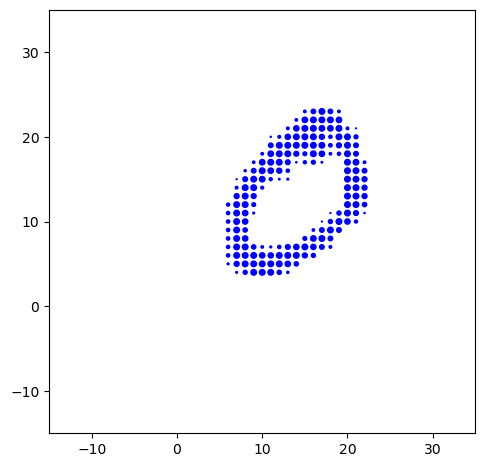

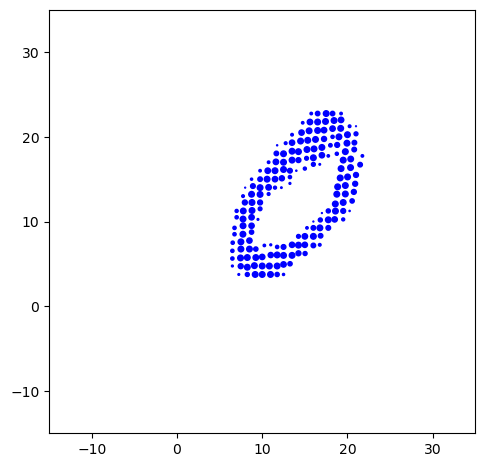

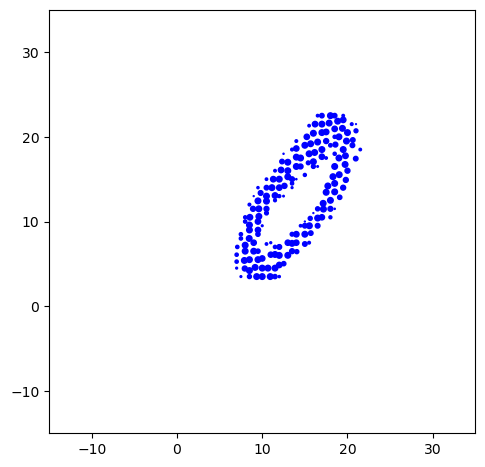

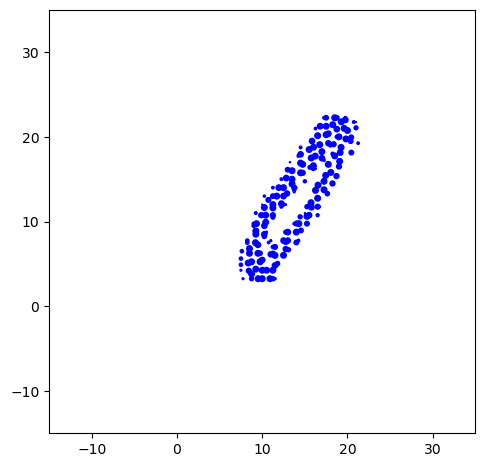

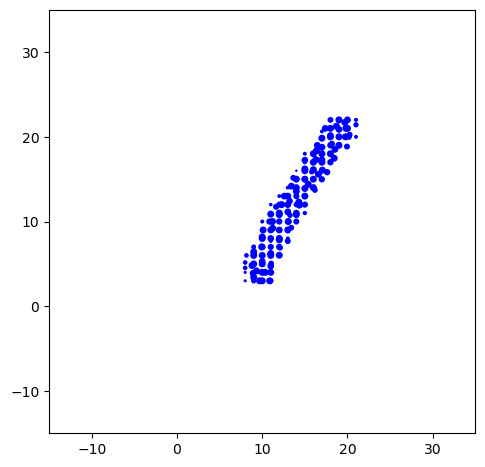

done


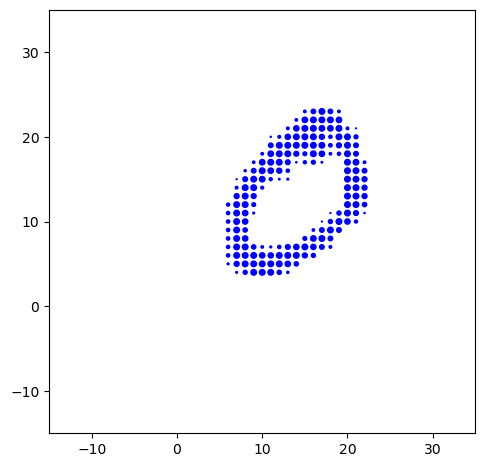

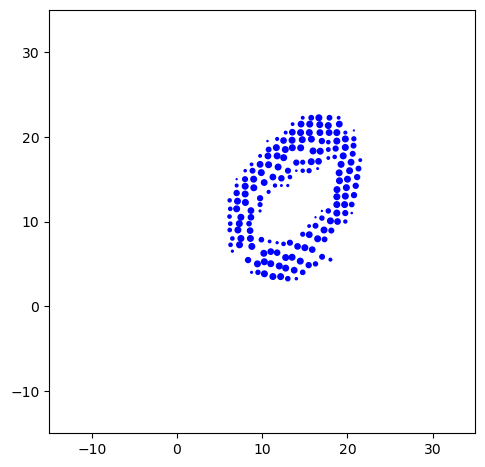

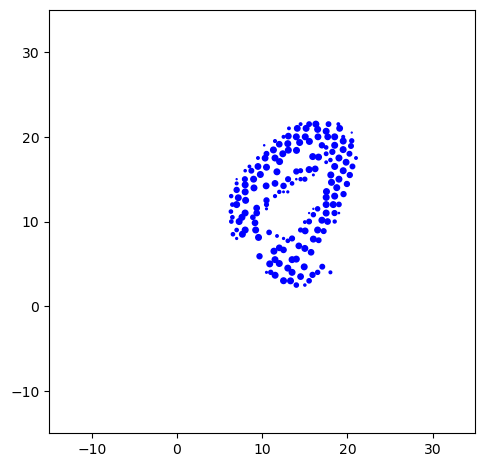

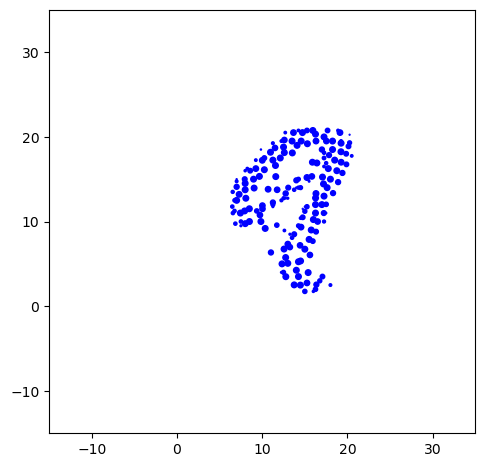

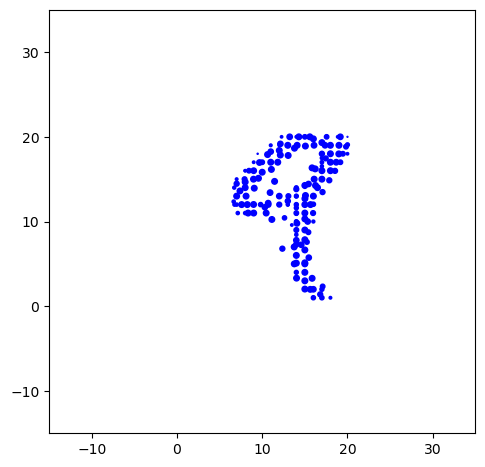

done


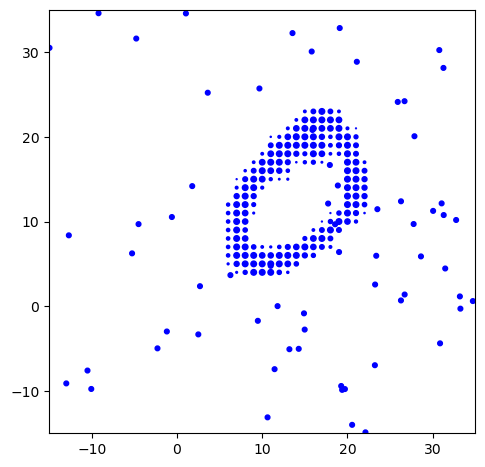

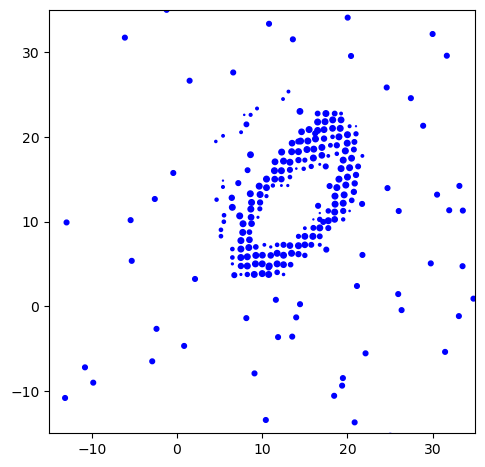

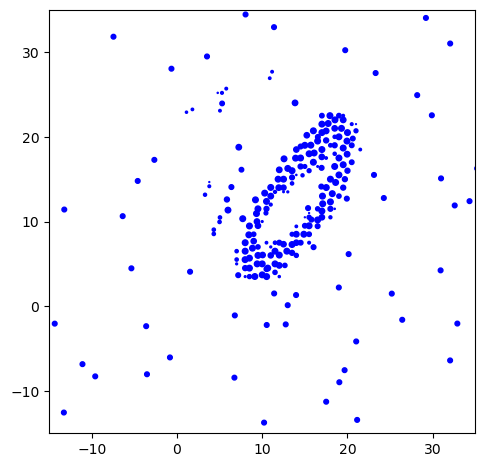

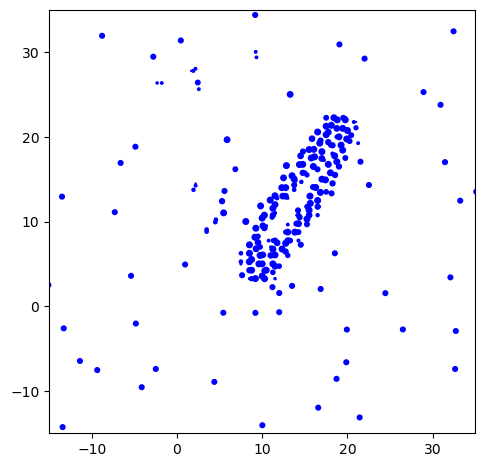

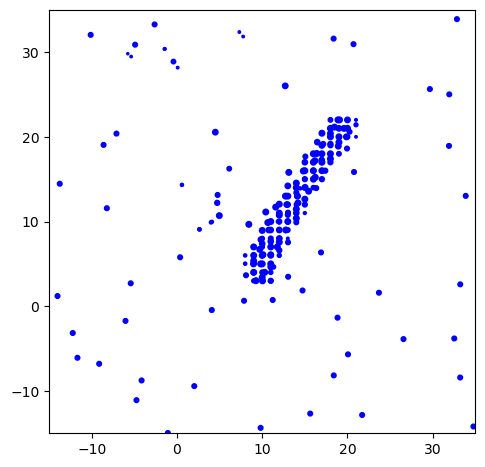

done


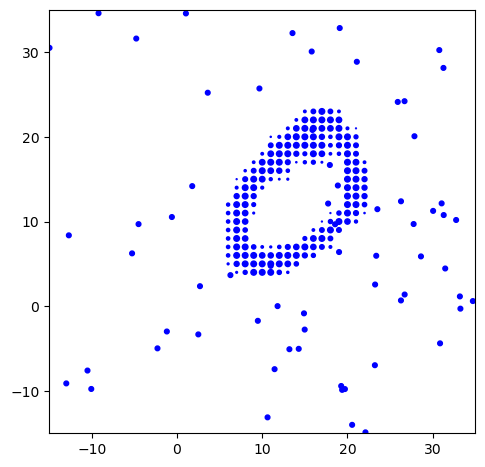

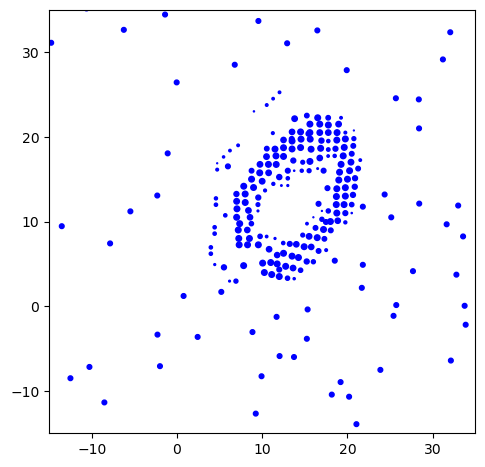

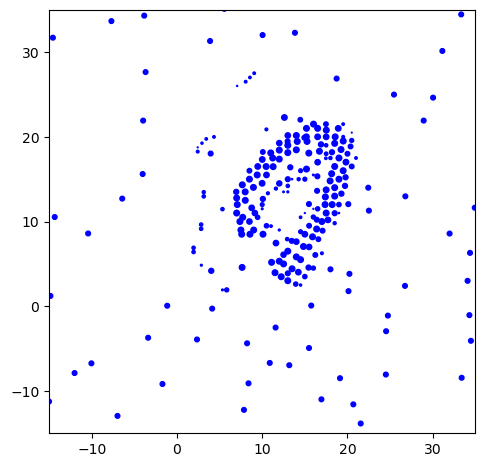

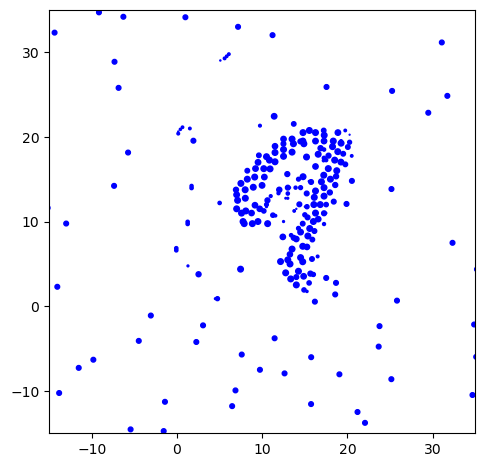

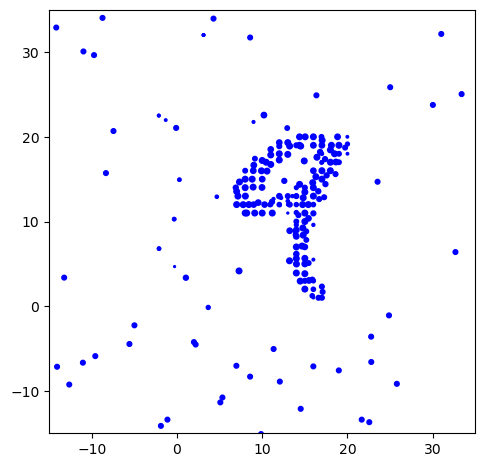

done


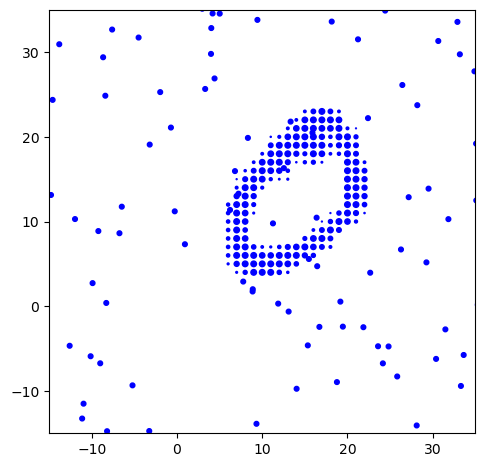

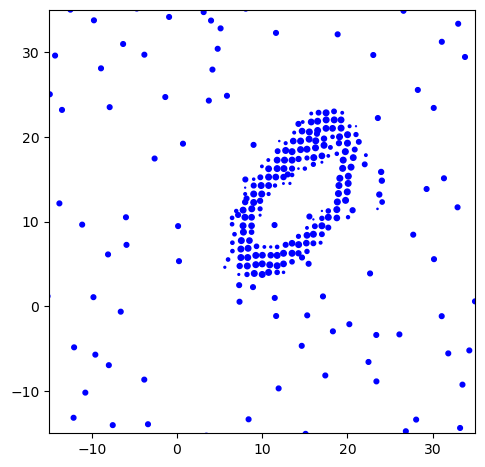

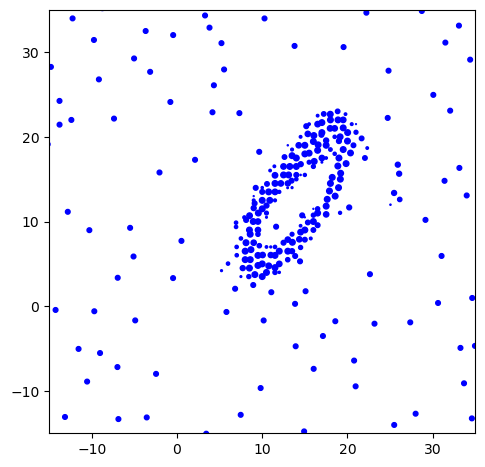

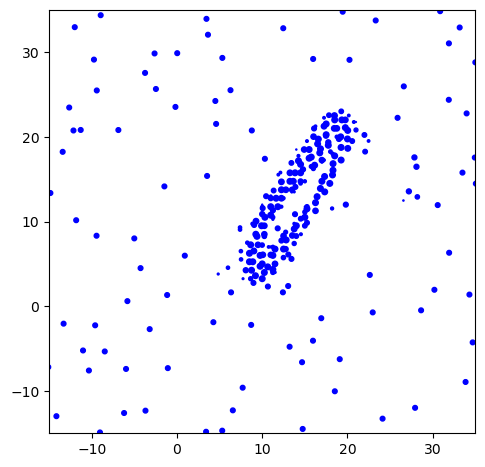

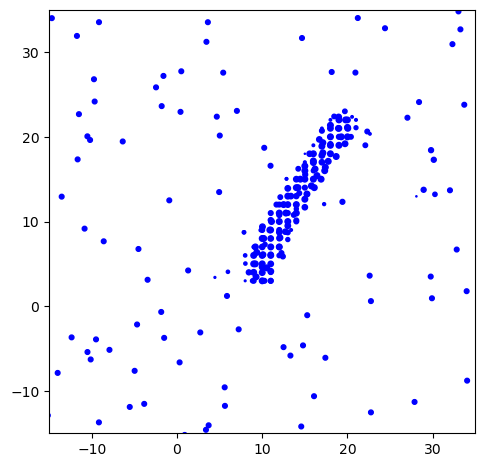

done


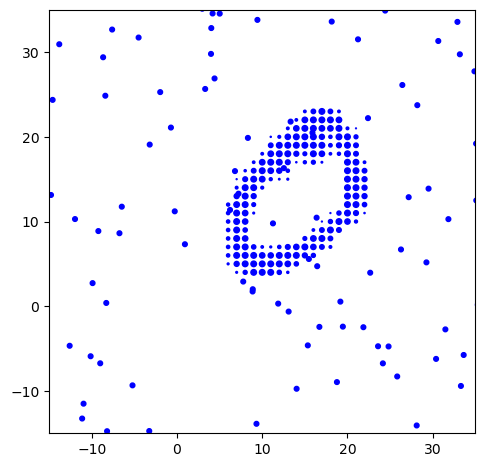

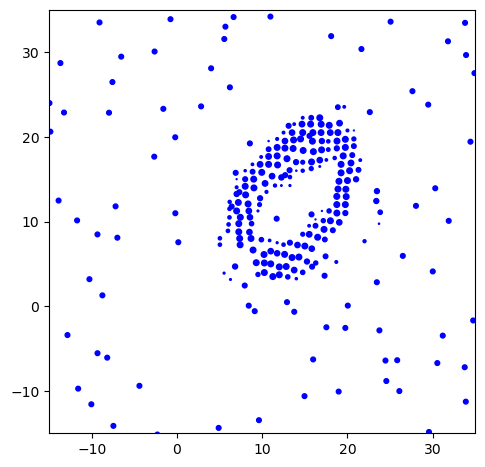

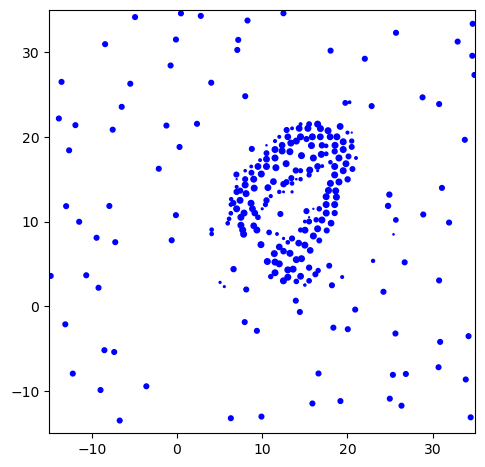

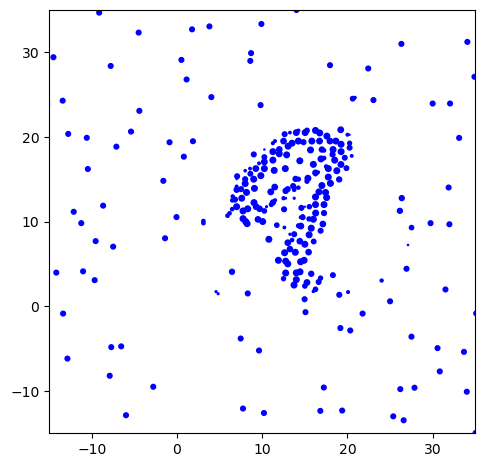

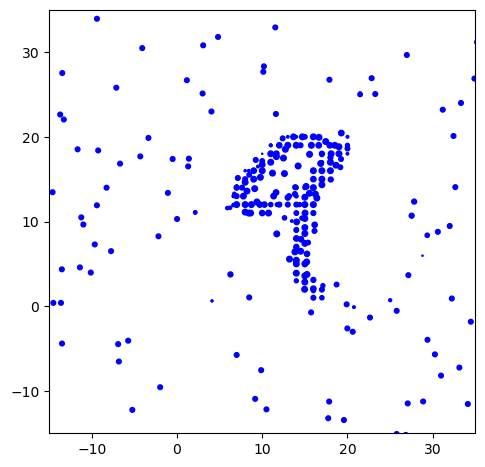

done


In [33]:
# OT geodesic
data_list=torch.load('experiment/geodesic/data/MNIST_019.pt')
tN=5
L=[[0,1],[0,2]]

xlim=(-15,35)
ylim=(-15,35)
    
#fig,ax=plt.subplots(1,k,figsize=(k*3,3))
for label in [0,0.5,0.75]: 
    for (i,j) in L:
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)+'/'
        X,p=data_list['data_'+str(label)]
        Xi=X[i].copy()
        Xj=X[j].copy()
        pi=p[i]
        pj=p[j]
        Uj=lot_embedding(Xi,Xj,pi,pj)
        Xt_list_ot=ot_geodesic(Xi,Uj,np.linspace(0,1,tN))
    
        ind=0
        ot_result=list()
        for t in np.linspace(0,1,tN):
            Xt=Xt_list_ot[ind]
            name=save_path+'X_ot_t='+str(t)+'.pdf'
            scatter_2d(Xt,pi,xlim=xlim,ylim=ylim,name=name)
            ot_result.append((Xt,pi))
            ind+=1
        torch.save(ot_result,save_path+'ot_result.pt')
        print('done')


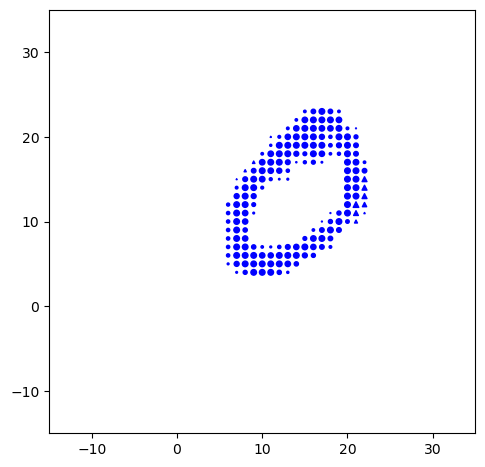

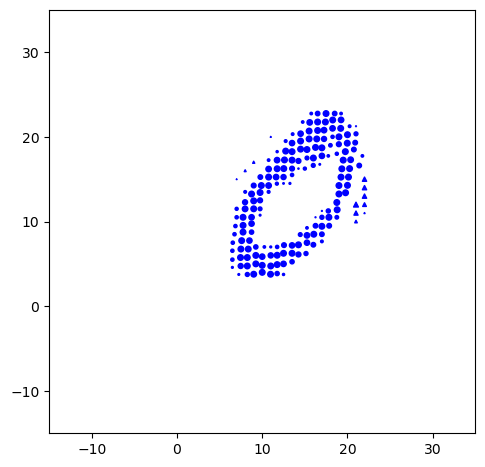

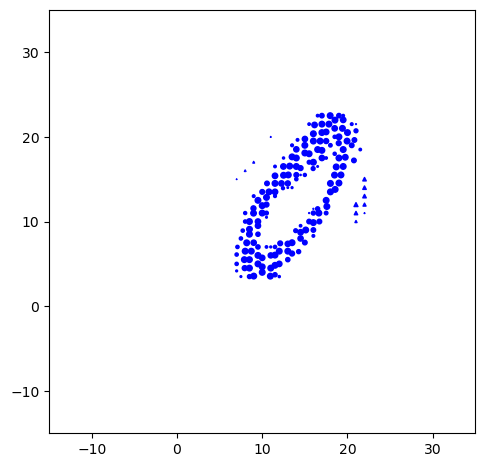

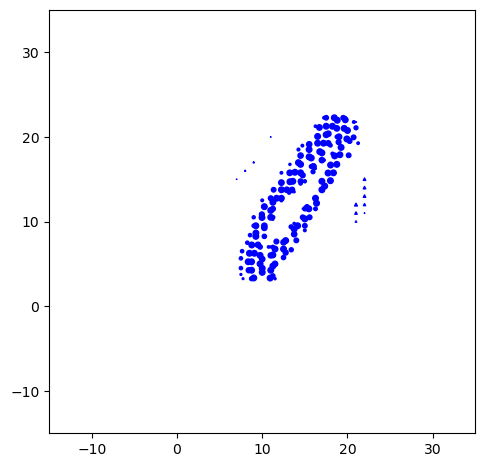

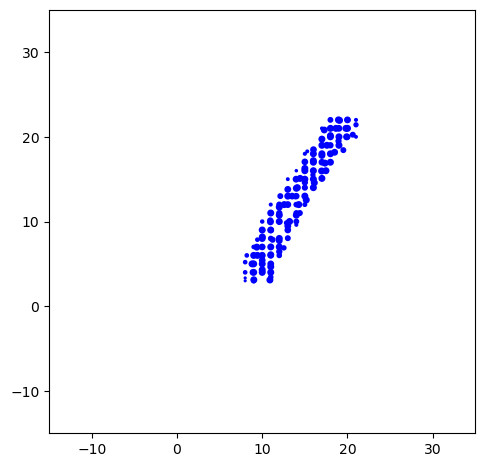

done


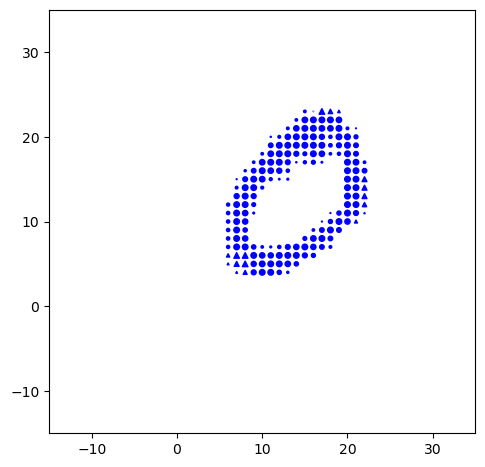

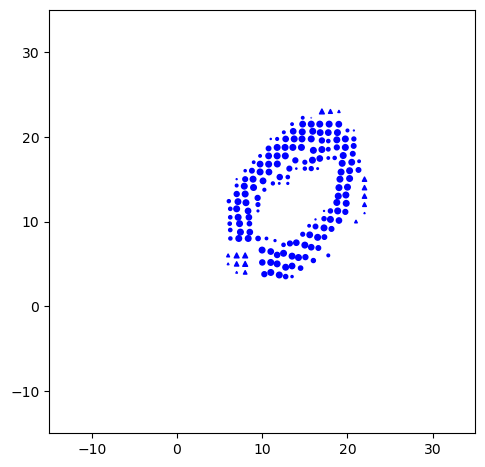

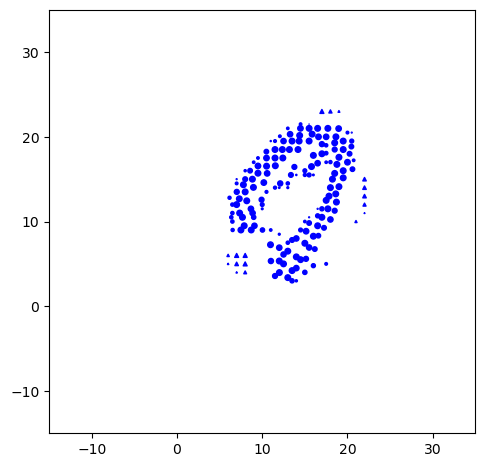

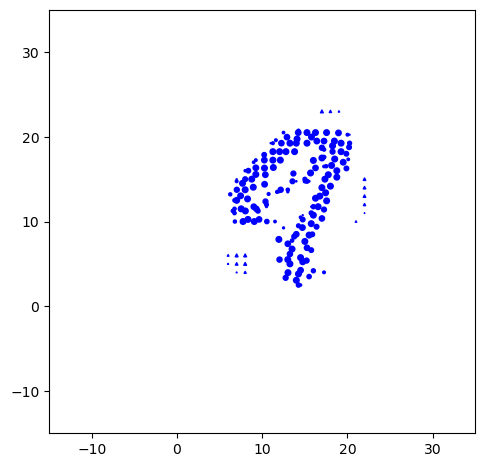

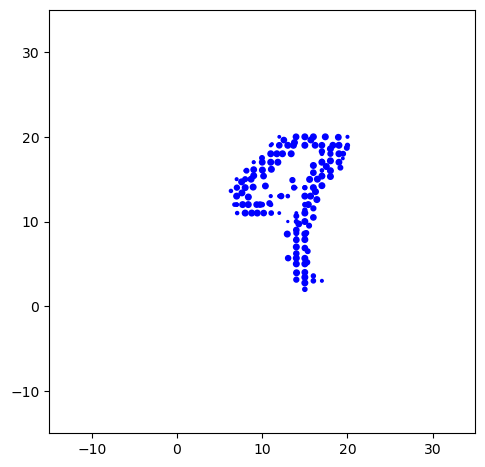

done


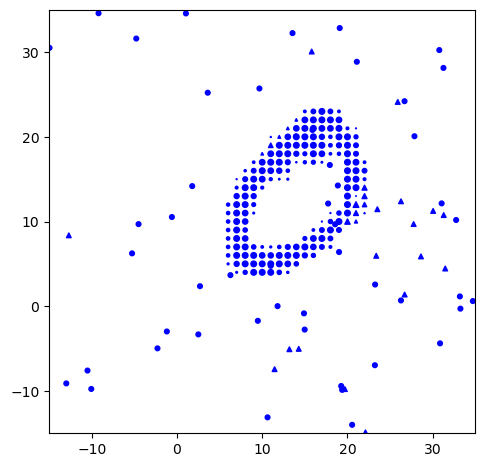

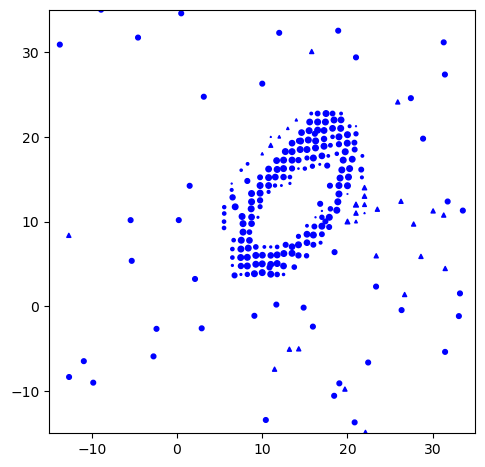

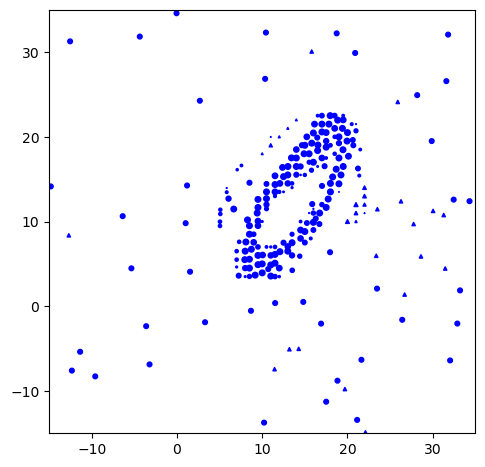

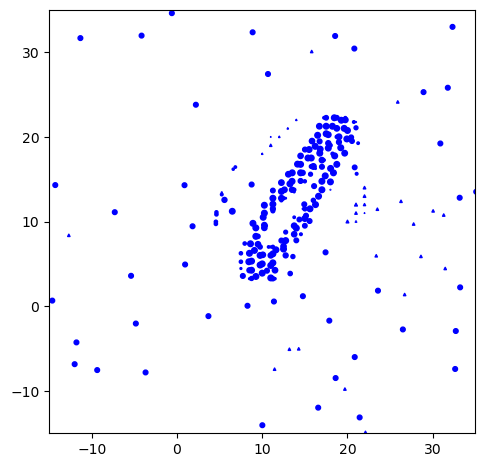

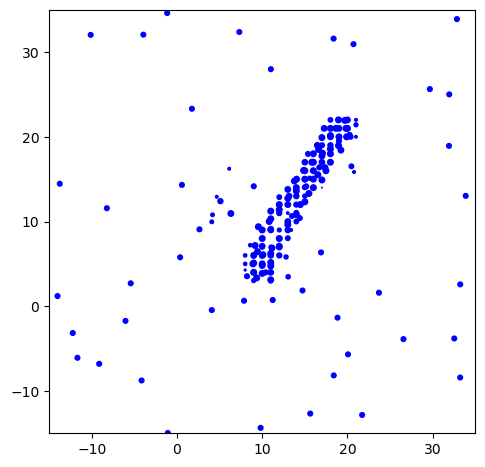

done


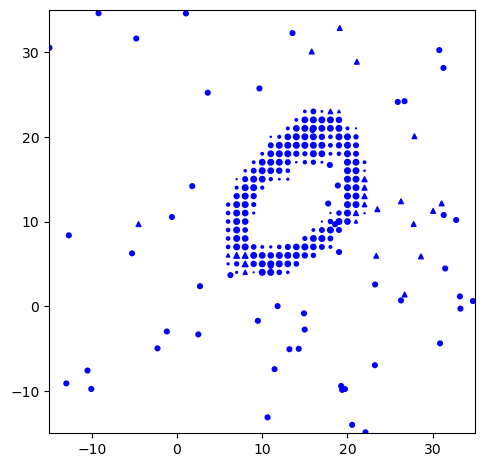

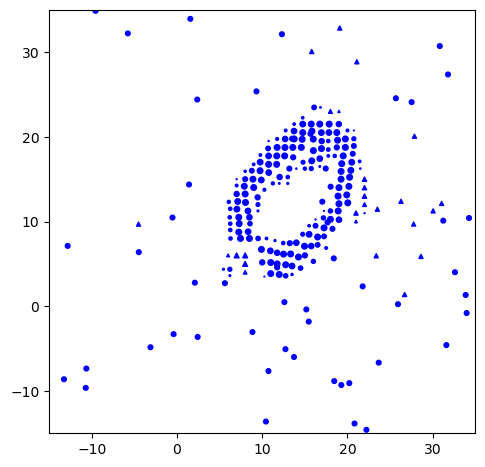

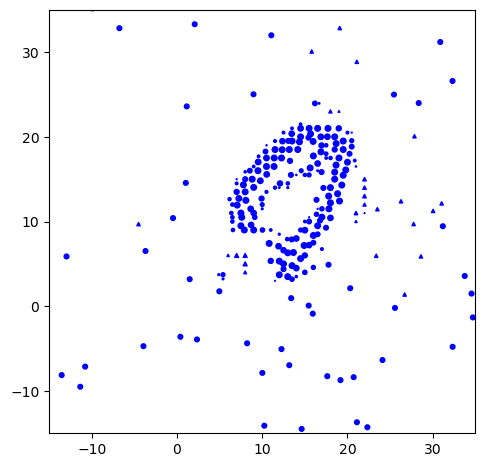

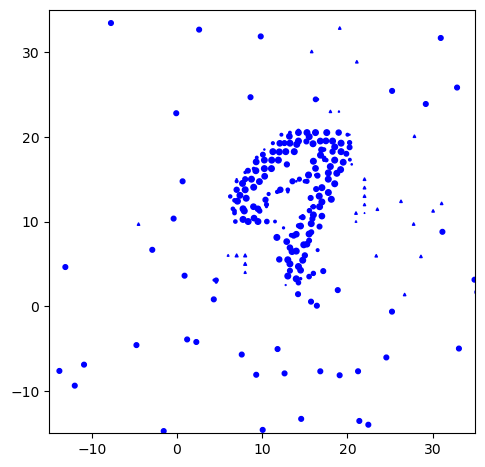

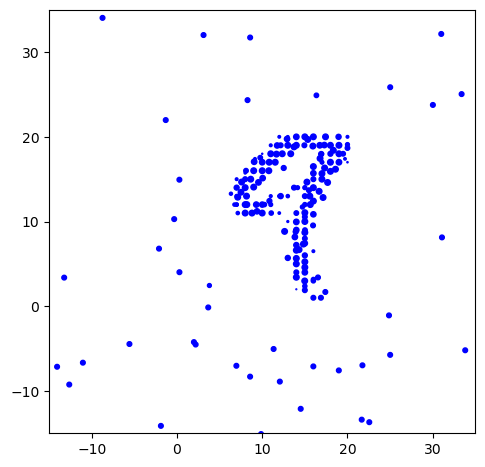

done


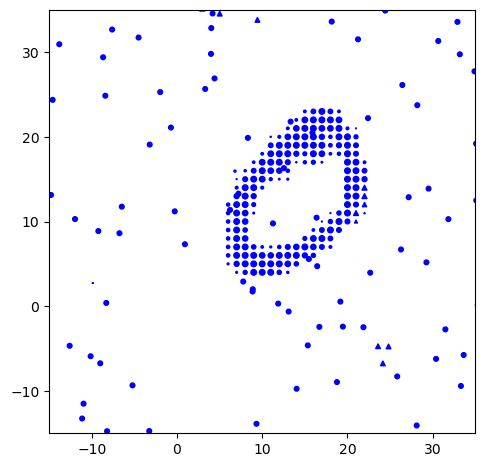

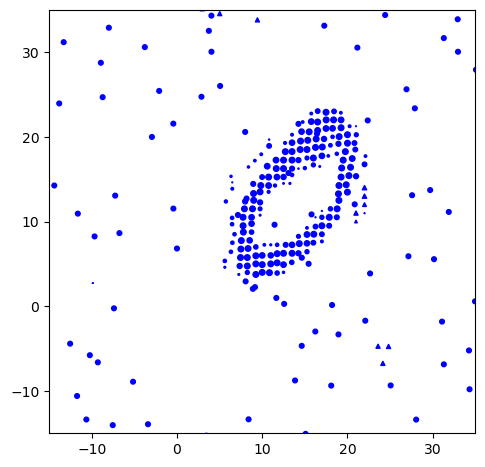

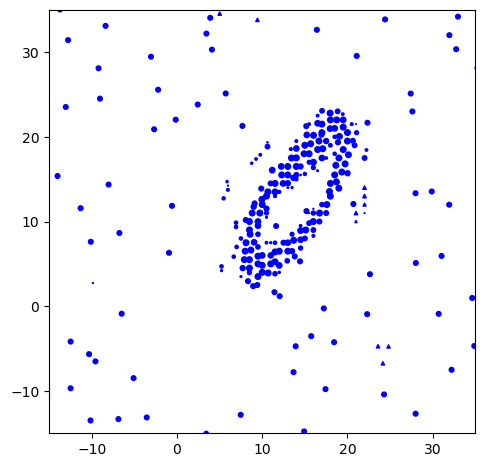

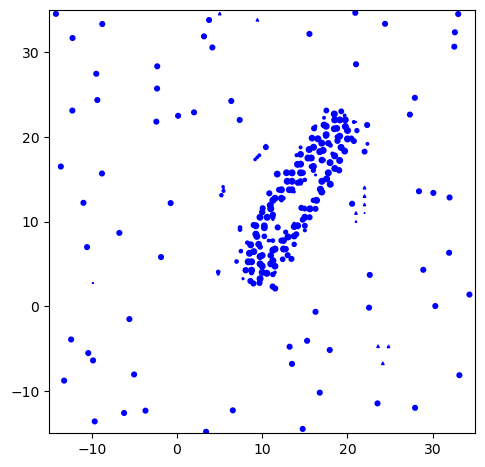

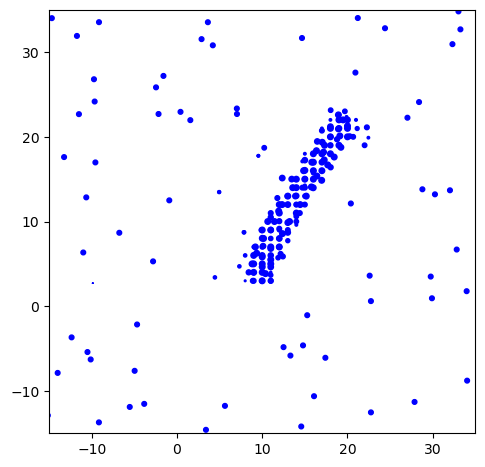

done


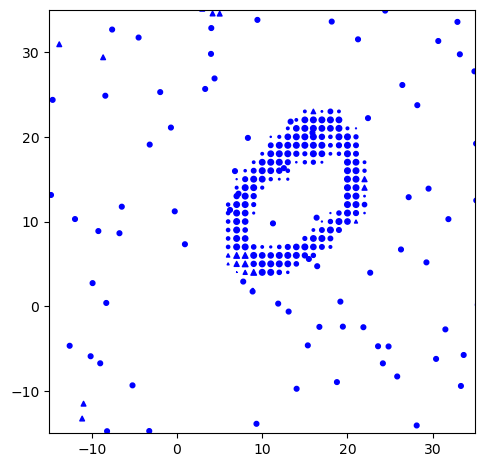

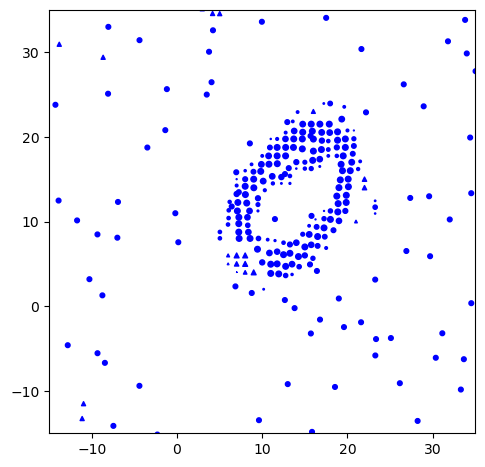

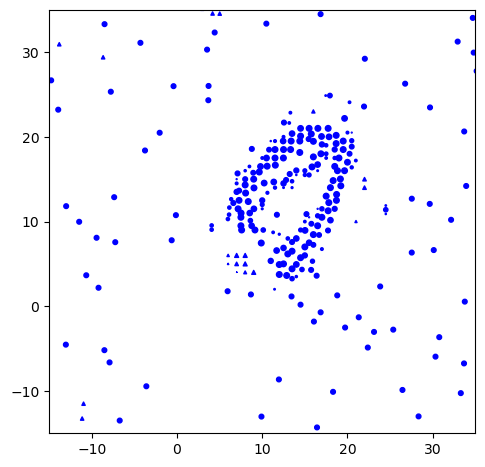

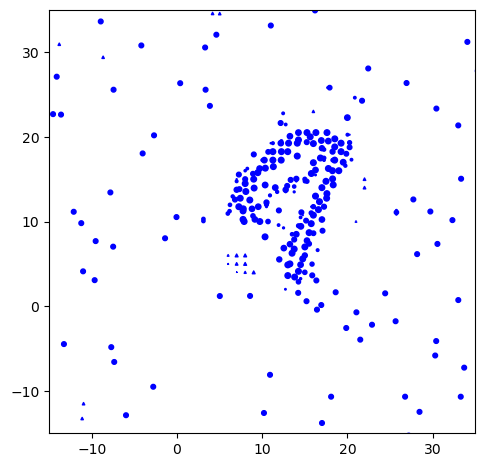

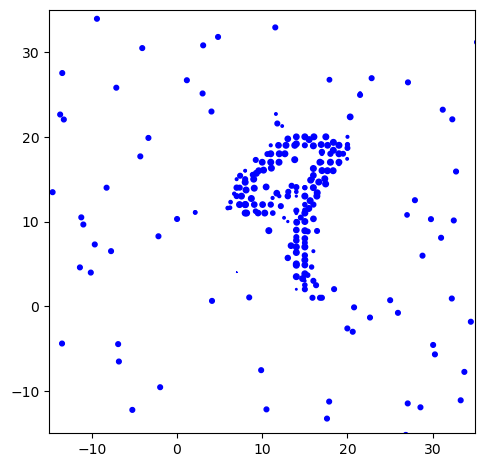

done


In [35]:
#opt interporlation
tN=5
L=[[0,1],[0,2]]
Lambda=20.0
data_list=torch.load('experiment/geodesic/data/MNIST_019.pt')
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]: 
    for (i,j) in L:
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)+'/'
               
        X,p=data_list['data_'+str(label)]
        Xi=X[i].copy()
        Xj=X[j].copy()
        pi=p[i] #np.ones(Xi.shape[0])/Ni0
        pj=p[j] #np.ones(Xj.shape[0])/Nj0
        Uj,pj_hat,Mj=lopt_embedding(Xi,Xj,pi,pj,Lambda)
        Xt_list,pt,X_d,p_d=opt_interpolation(Xi,Uj,pi,pj_hat,np.linspace(0,1,tN))   # (X0,U1,p0,p1_hat,t_list)
       
        ind=0
        opt_result=[]
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'X_opt_t='+str(t)+'.pdf'
            scatter_2d(Xt,pt,X_d=X_d,p_d=(1-t)*p_d,xlim=xlim,ylim=ylim,name=name)
            opt_result.append((Xt,pt,X_d,(1-t)*p_d))
            ind+=1
        torch.save(opt_result,save_path+'/opt_result.pt')
        print('done')
        

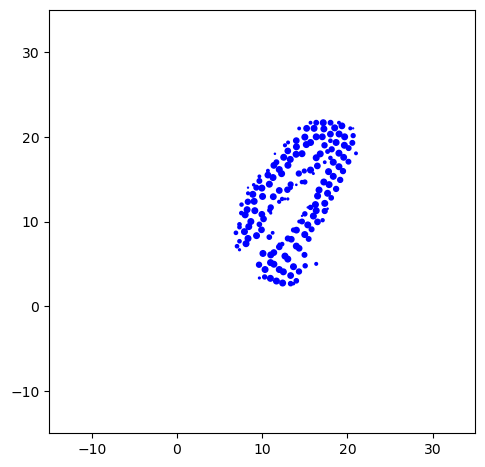

In [37]:
#LOT interpolation 

# compute barycenter 
data_list=torch.load('experiment/geodesic/data/MNIST_019.pt')

X,p=data_list['data_0']
X1,X2,X3=(X[0],X[1],X[2])
p1,p2,p3=(p[0],p[1],p[2])
N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
p0=p1 #np.ones(N)/N
X0_init=X1
Xi_list=[X1,X2,X3]
pi_list=[p1,p2,p3]
weights=np.ones(3)/3
X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)

scatter_2d(X0,p0,xlim=xlim,ylim=ylim)
   


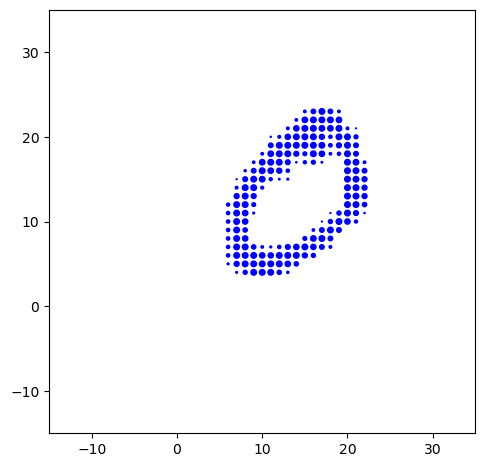

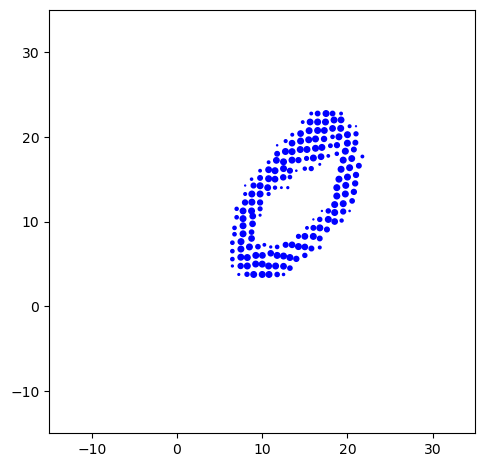

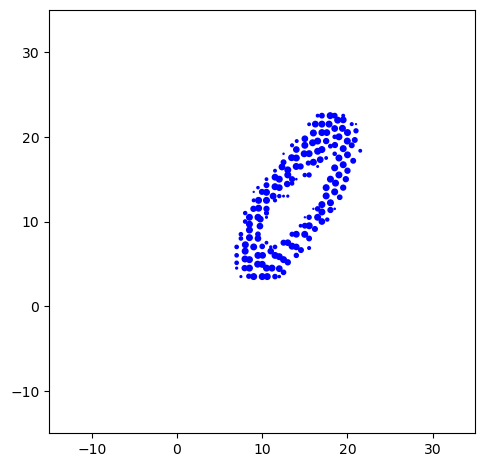

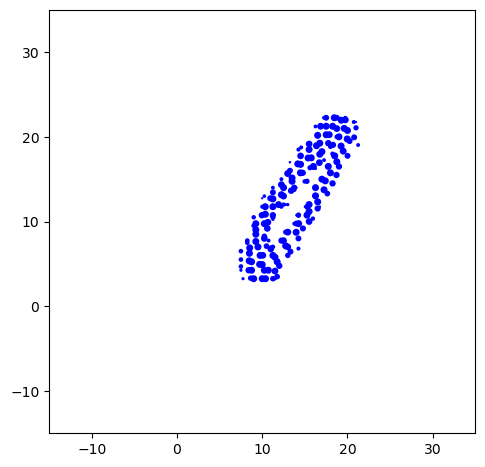

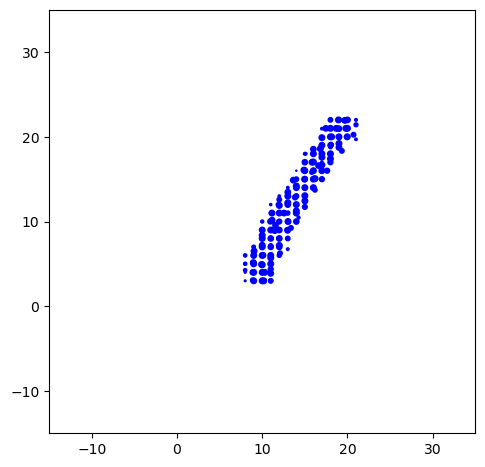

end


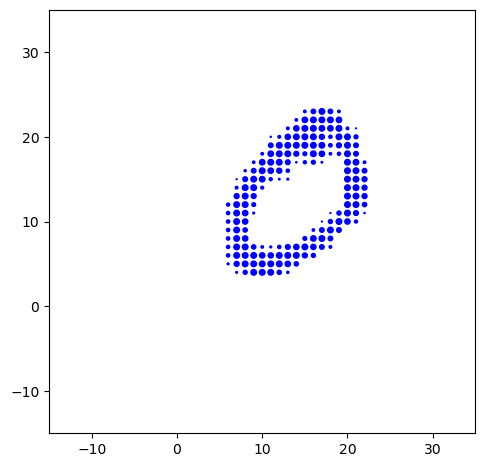

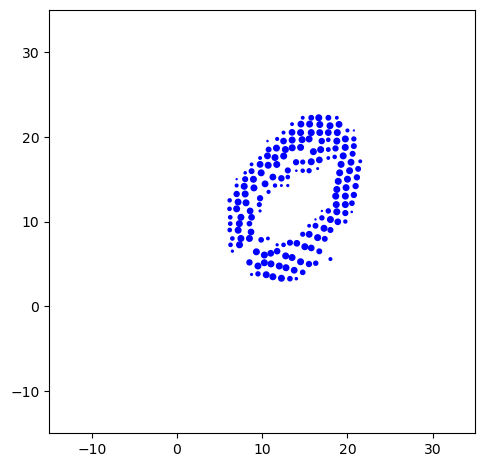

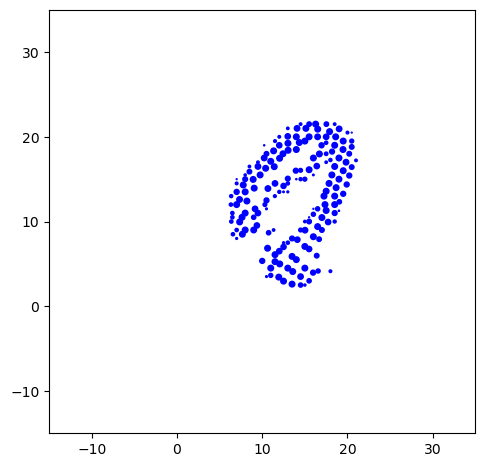

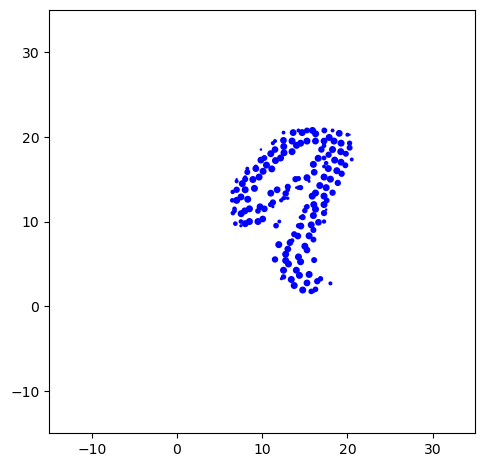

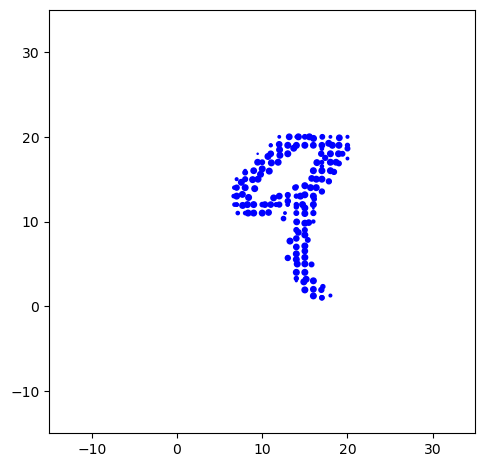

end


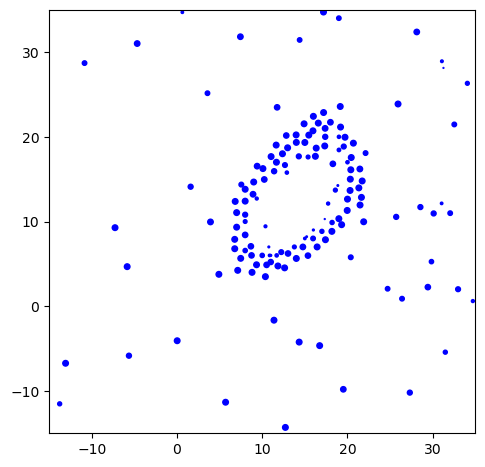

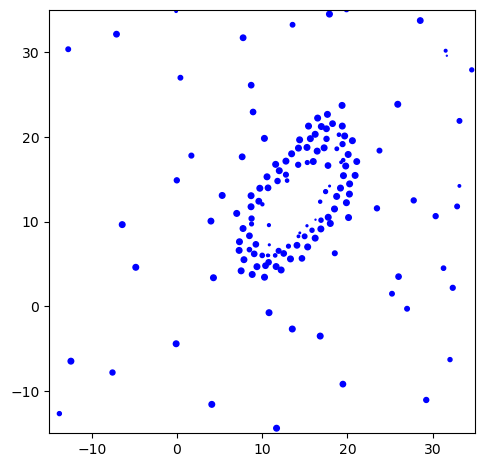

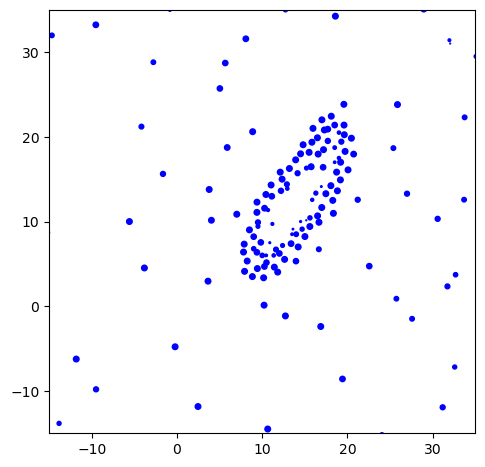

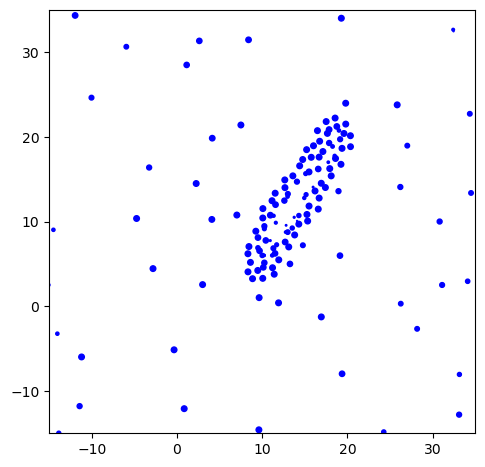

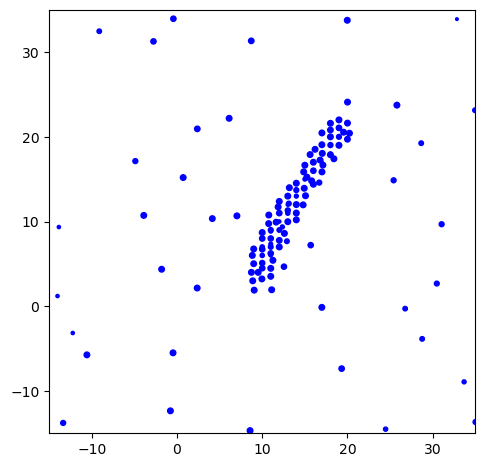

end


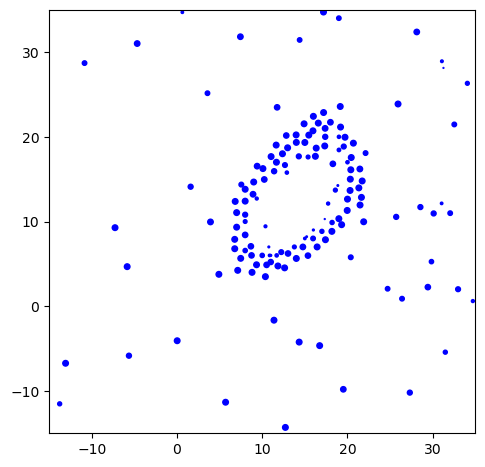

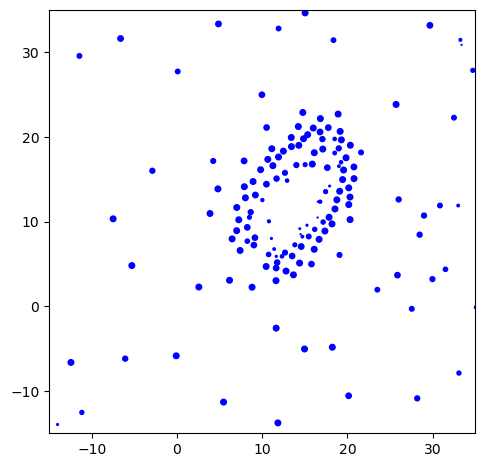

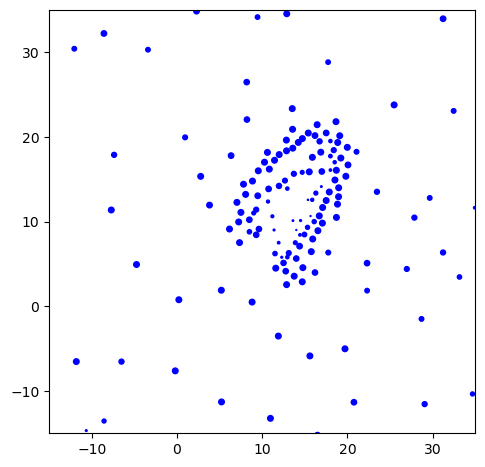

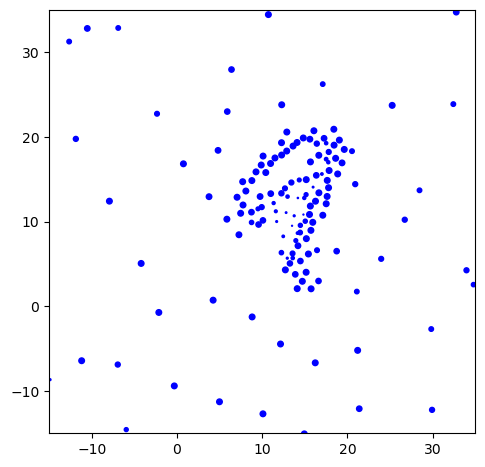

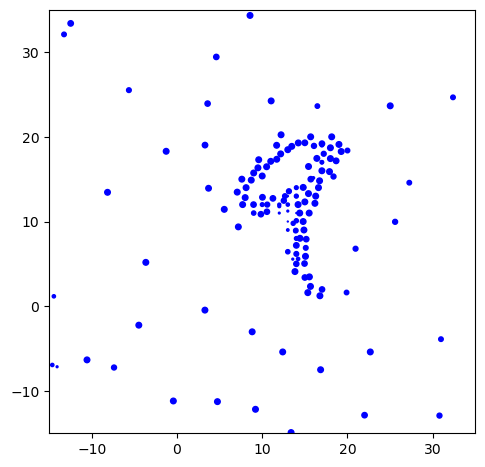

end


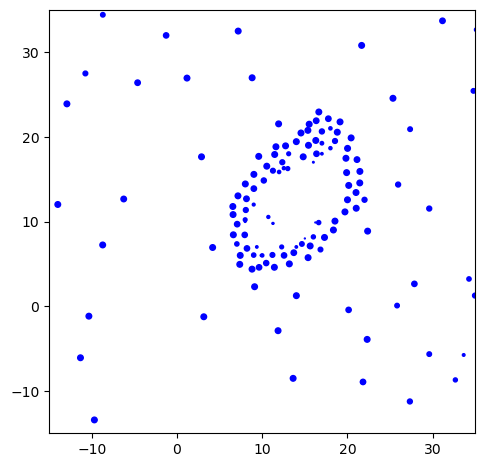

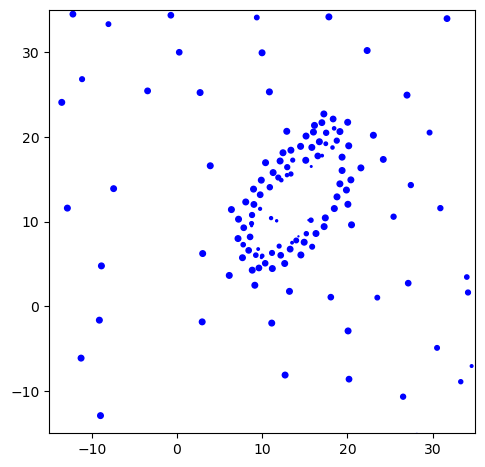

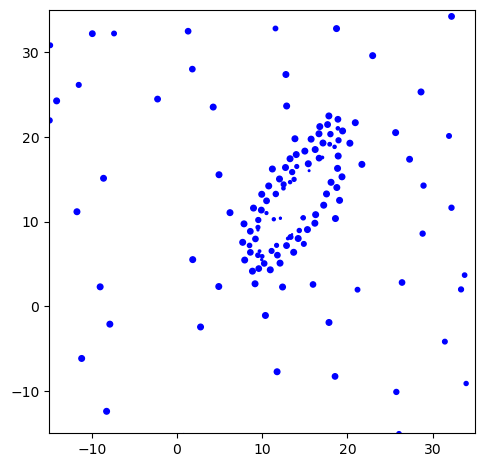

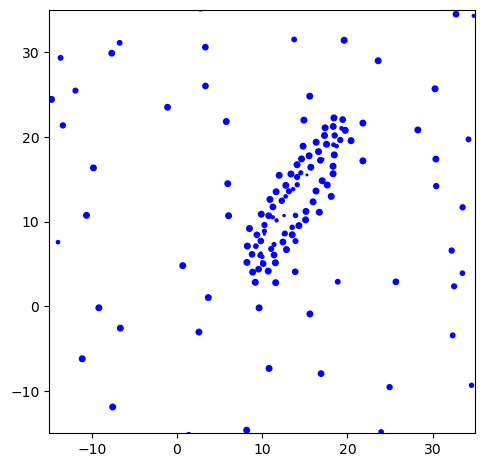

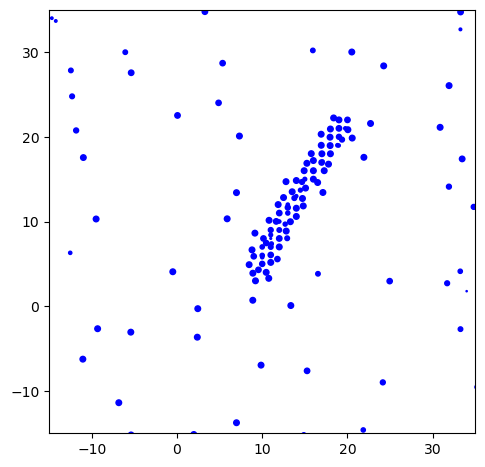

end


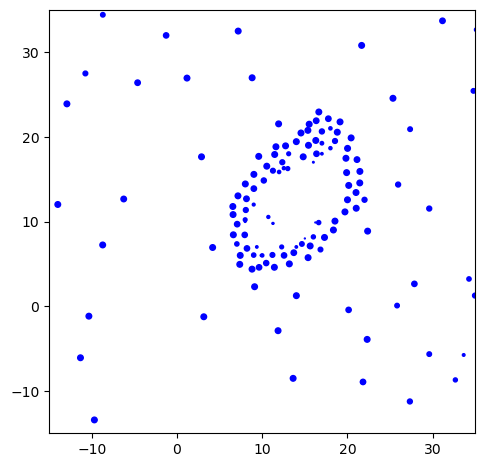

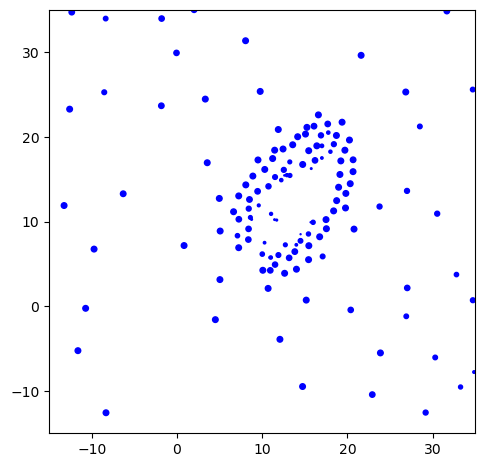

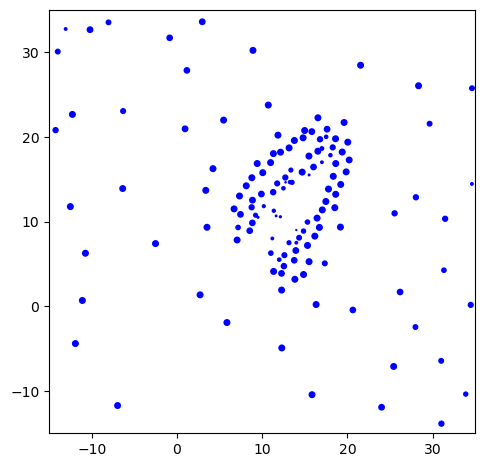

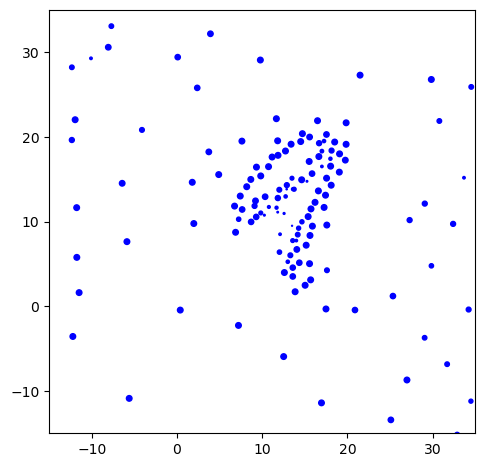

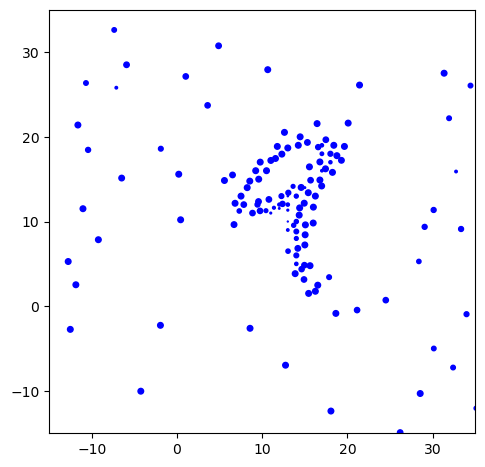

end


In [38]:
#LOT interpolation 
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]:
    # X1,X2,X3=(X[0],X[1],X[2])
    # p1,p2,p3=(p[0],p[1],p[2])
    # #N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
    # X0_init=np.random.uniform(low=[5,5],high=[25,25],size=[N00,2])
    # p0=np.ones(N00)/N00
    # Xi_list=[X1,X2,X3]
    # pi_list=[p1/np.sum(p1)*np.sum(p0),p2/np.sum(p1)*np.sum(p0),p3/np.sum(p3)*np.sum(p0)]
    # weights=np.ones(3)/3
    # X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)
    
    U_lot=list()
    
    X,p=data_list['data_'+str(label)]
    for k in range(M):
        Xk=X[k].copy()
        pk=p[k]
        pk=pk/np.sum(pk)*np.sum(p0)
        Uk_lot=lot_embedding(X0,Xk,p0,pk)
        U_lot.append(Uk_lot)
    #torch.save(U_lot,'experiment/geodesic/result/MNIST/U_lot'+str(label)+'.pt')
 
    for (i,j) in L:
        
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)
        Xi=X[i].copy()
        Xj=X[j].copy()
        Ui=U_lot[i]
        Uj=U_lot[j]

        #X_alpha=lot_geodesic(X0,Ui,Uj,alpha)

        Xt_list=lot_geodesic(X0,Ui,Uj,np.linspace(0,1,tN))
        ind=0
        lot_result=[]
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'/'+'X_lot_t='+str(t)+'.pdf'
            scatter_2d(Xt,p0,xlim=xlim,ylim=ylim,name=name)
            lot_result.append((Xt,p0))
            ind+=1   
        torch.save(lot_result,save_path+'/lot_result.pt')
        print('end')
        

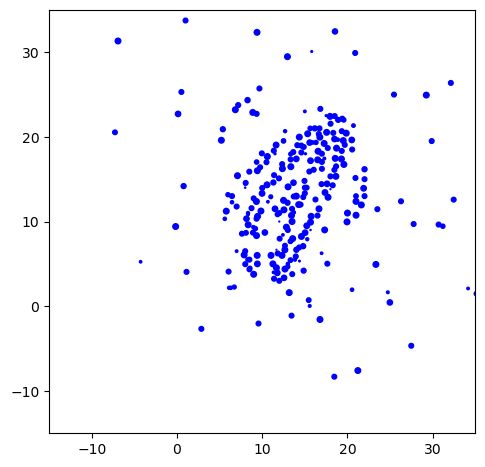

In [39]:
data_list=torch.load('experiment/geodesic/data/MNIST_019.pt')
Lambda=20.0
X,p=data_list['data_0.5']
X1,X2,X3=(X[0],X[1],X[2])
p1,p2,p3=(p[0],p[1],p[2])
N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
p0=p1 #np.ones(N)/N
#N0=p1.shape[0]
X0_init=X1
X0_init=np.random.uniform([5,5],[25,25],[X1.shape[0],2])
Xi_list=[X1,X2,X3]
pi_list=[p1,p2,p3]
weights=np.ones(3)/3

X0=lopt_barycenter(Xi_list,pi_list,X0_init,p0,weights, Lambda, numItermax=10000,stopThr=1e-7)
#p0=p0
scatter_2d(X0,p0,xlim=xlim,ylim=ylim,name=name)

#X0=np.random.uniform(low=[5,5],high=[25,25],size=(N0,2))

label 0


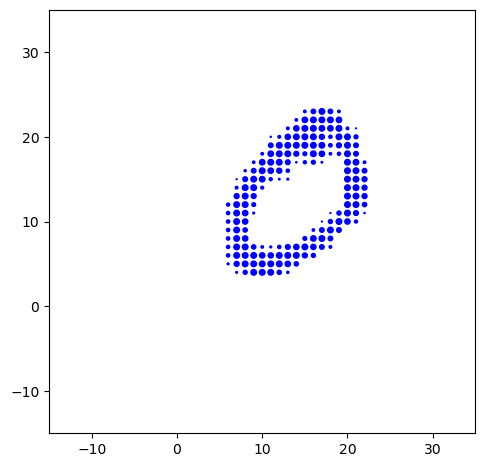

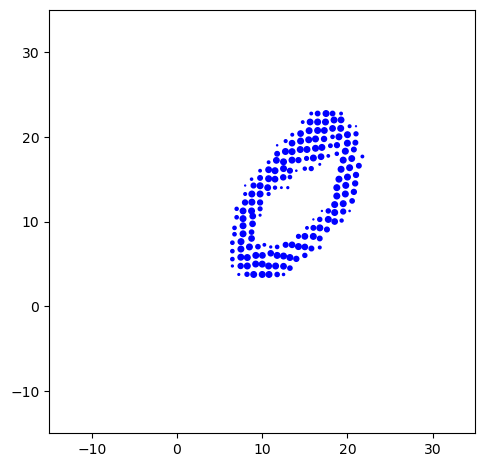

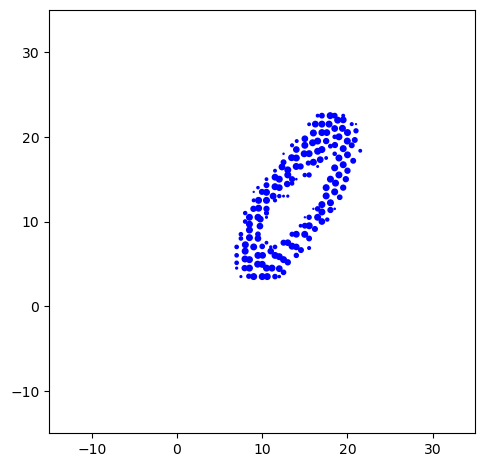

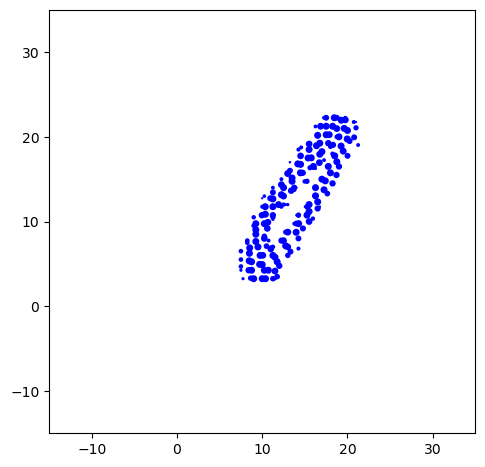

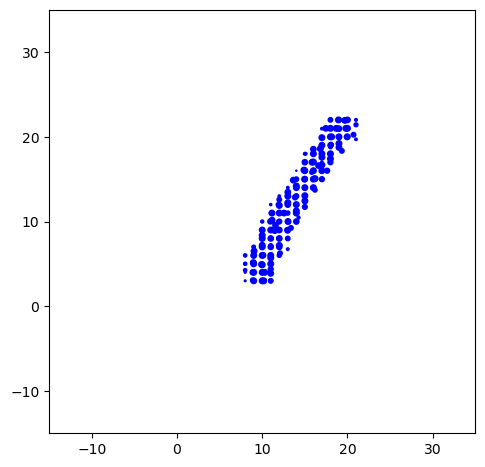

end


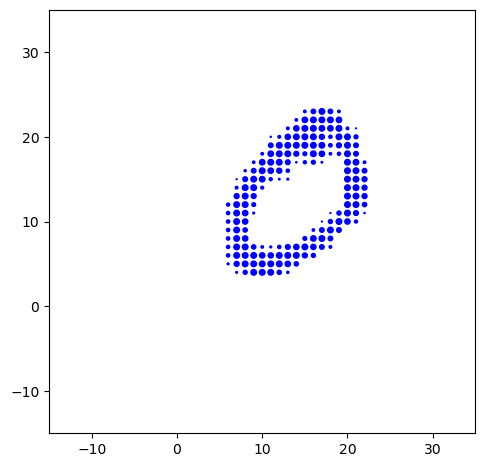

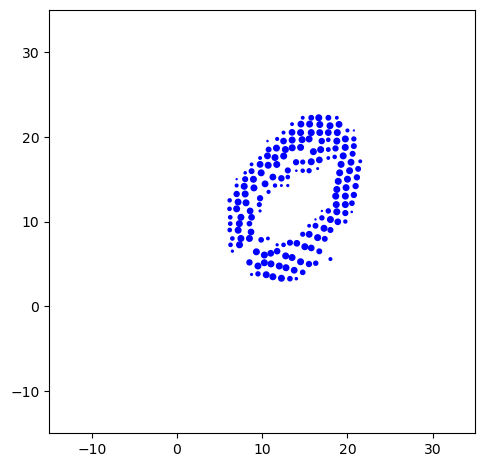

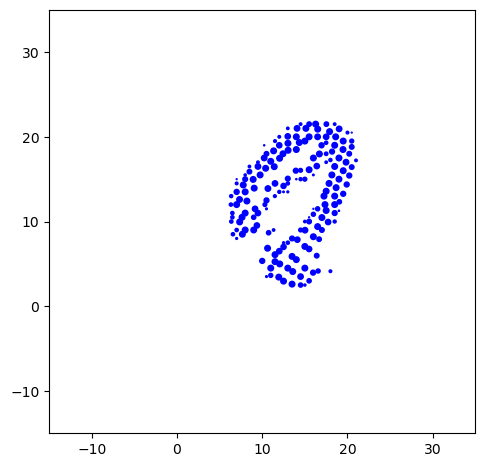

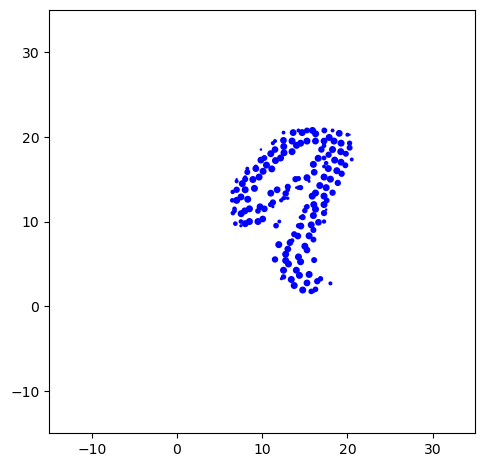

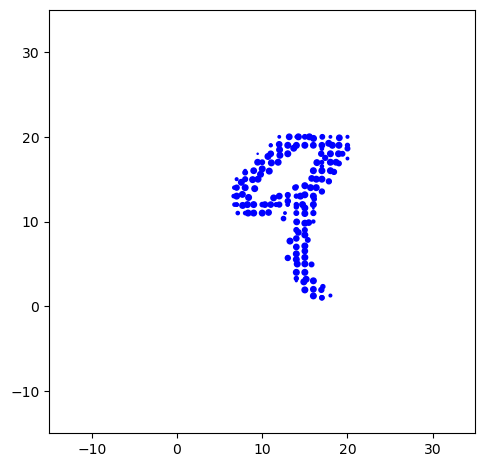

end
label 0.5


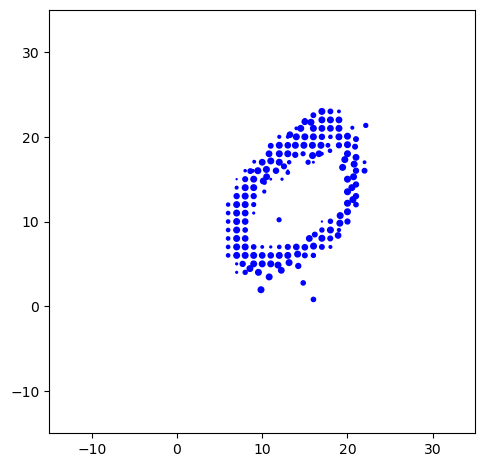

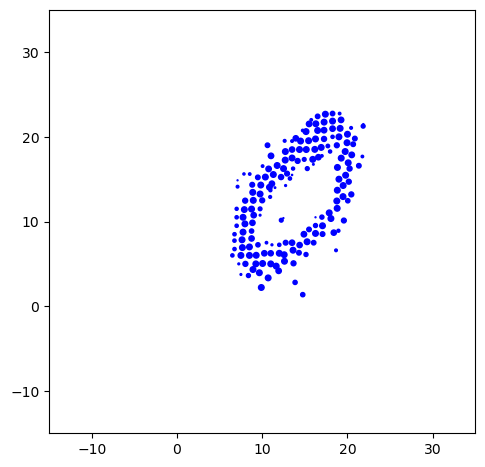

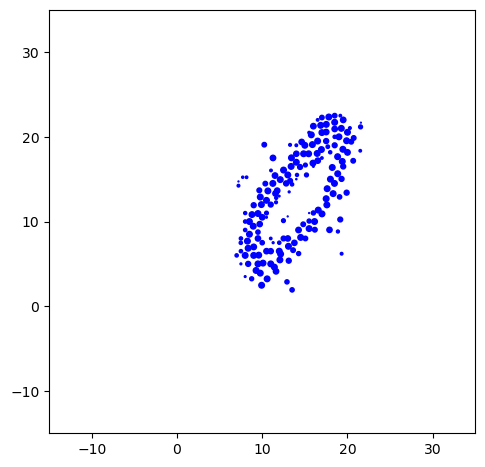

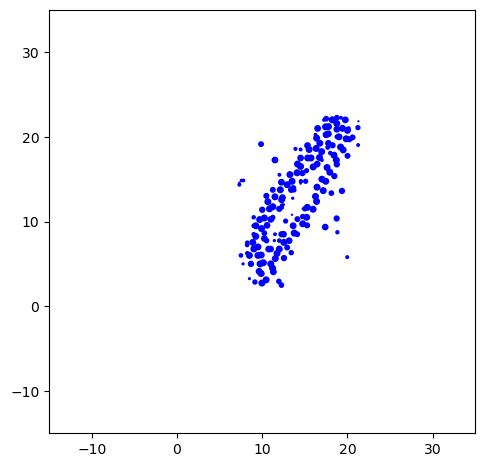

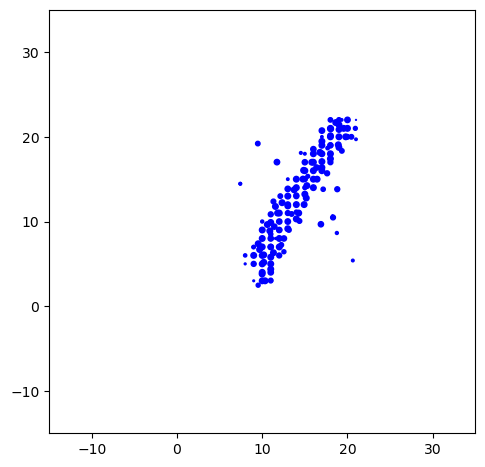

end


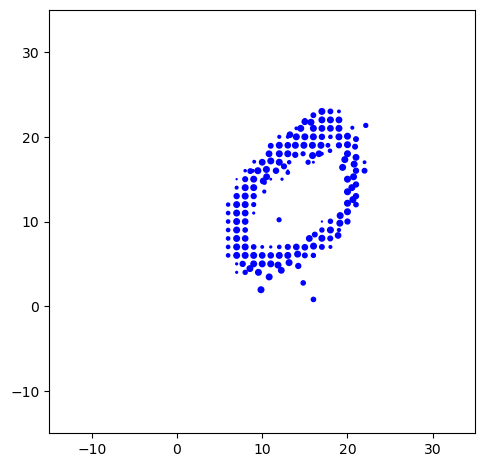

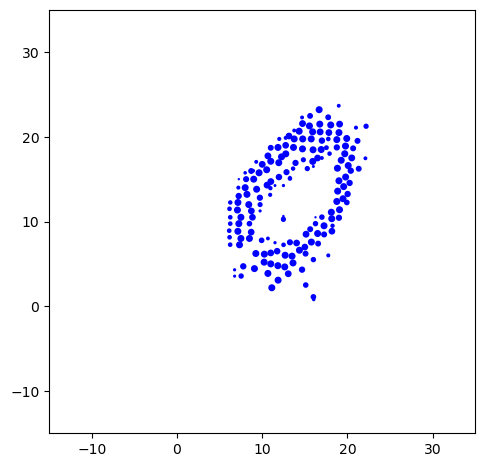

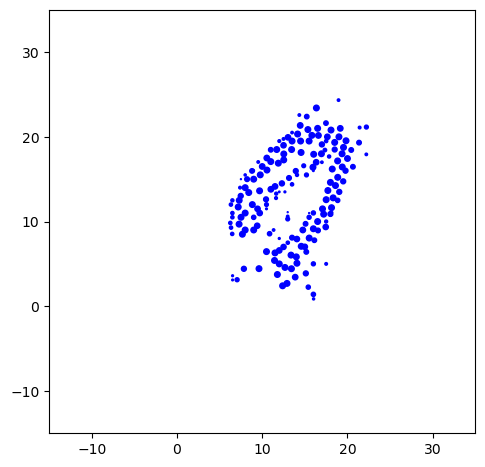

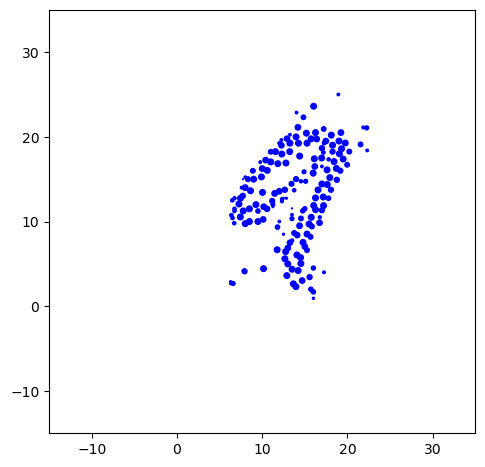

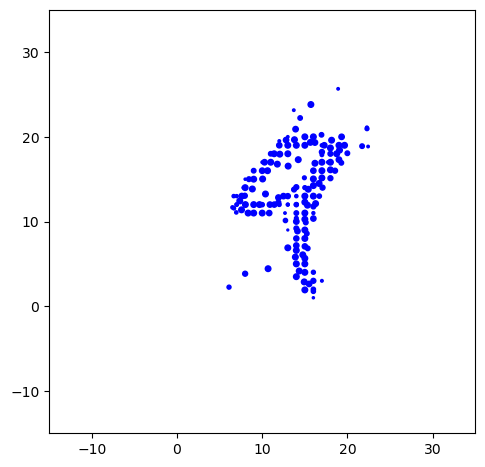

end
label 0.75


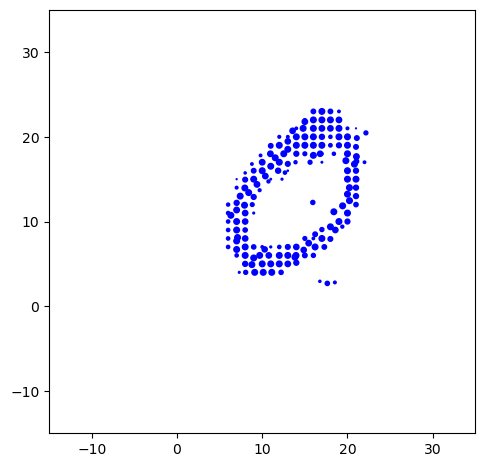

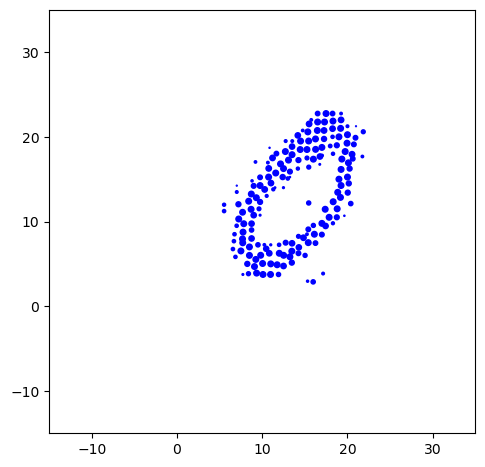

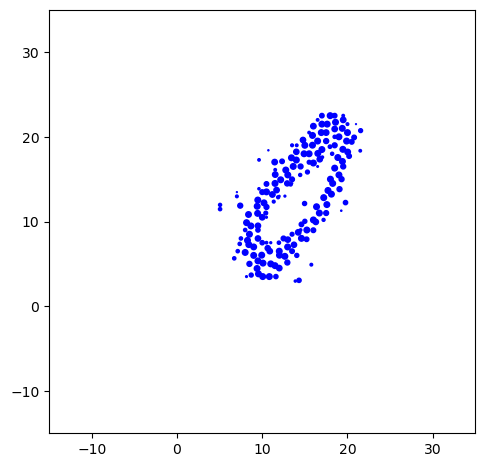

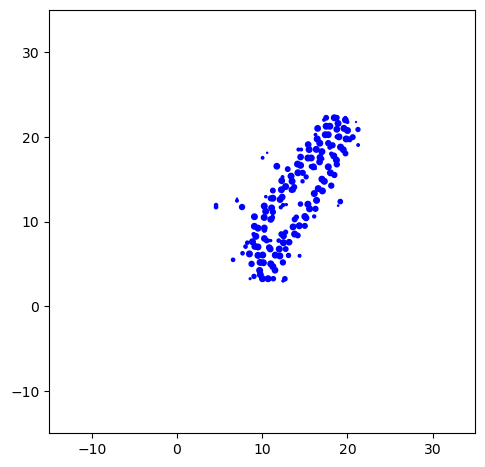

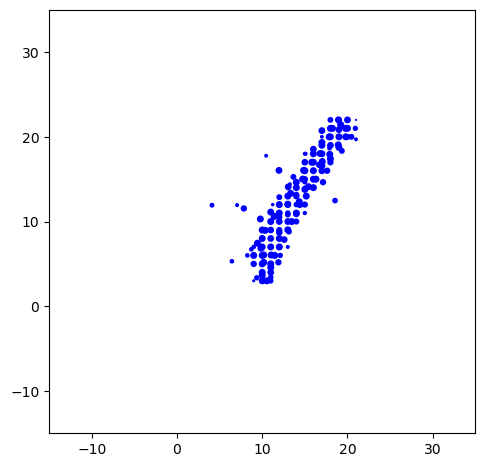

end


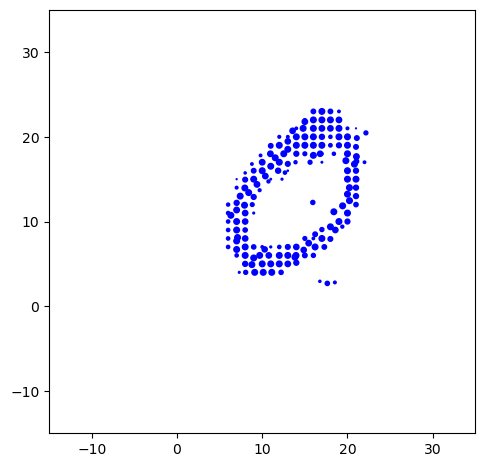

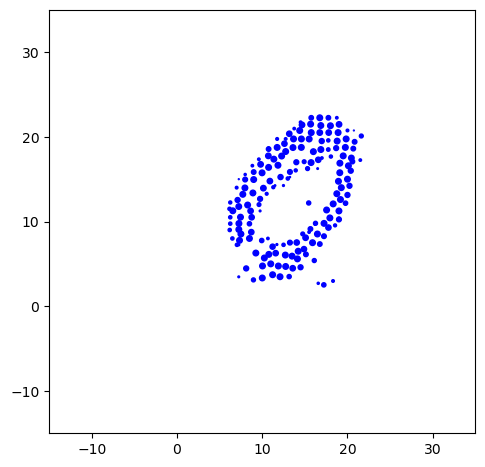

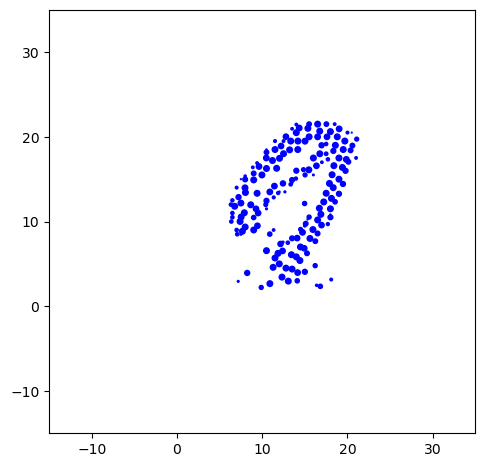

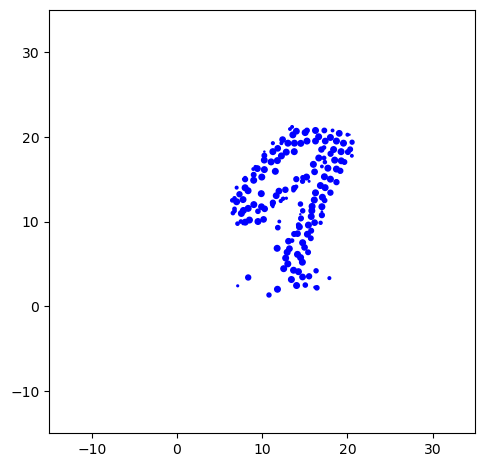

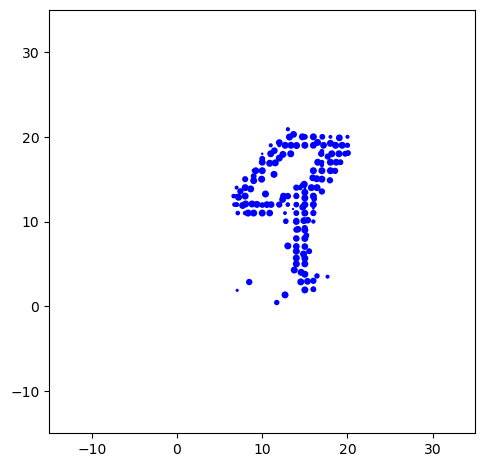

end


In [285]:
#lopt interporlation
tN=5
L=[[0,1],[0,2]]
Lambda=30.0

xlim=(-3,25)
ylim=(-5,25)

#LOT interpolation 
xlim=(-15,35)
ylim=(-15,35)

for label in [0,0.5,0.75]:
    print('label',label)
    lopt_E=list()
    X,p=data_list['data_'+str(label)]
#     # barycenter
#     X1,X2,X3=(X[0],X[1],X[2])
#     p1,p2,p3=(p[0],p[1],p[2])
#     N=np.max((X1.shape[0],X2.shape[0],X3.shape[0]))
    
#     X0_init=np.random.uniform(low=[5,5],high=[20,20],size=[N0,2])
#     p0=np.ones(N0)/N0

#     #p0=p0/np.sum(p0)
#     Xi_list=[X1,X2,X3]
#     pi_list=[p1/np.sum(p1),p2/np.sum(p2),p3/np.sum(p3)]
#     weights=np.ones(3)/3
#     #X0=lopt_barycenter(Xi_list,pi_list,X0_init,p0, weights,Lambda, numItermax=10000,stopThr=1e-7)
#     X0=lot_barycenter(Xi_list,pi_list,X0_init,p0, weights, numItermax=10000,stopThr=1e-7)
    
    for k in range(M):
        Xk=X[k]
        pk=p[k]
        Uk,pk_hat,Mk=lopt_embedding(X0,Xk,p0,pk,Lambda)
        lopt_E.append((Uk,pk_hat))
        Uk,pk_hat=lopt_E[-1]
        #scatter_2d(X0+Uk,pk_hat,xlim=xlim,ylim=ylim,name=name)
        
    #torch.save(lopt_E,'experiment/geodesic/result/MNIST/lopt_E'+str(label)+'.pt')
        
    for (i,j) in L:        
        save_path='experiment/geodesic/result/MNIST/'+str(label)+'_'+str(i)+str(j)
        Ui,pi_hat=lopt_E[i]
        Uj,pj_hat=lopt_E[j]
    
        Xt_list,pt,X_d,p_d,X_c,p_c=lopt_interpolation(X0,Ui,Uj,pi_hat,pj_hat,np.linspace(0,1,tN))
        #Xt_list_lopt,=lopt_geodesic(X0,Ui,Uj,np.linspace(0,1,tN))
        ind=0
        lopt_result=list()
        for t in np.linspace(0,1,tN):
            Xt=Xt_list[ind]
            name=save_path+'/X_lopt_t='+str(t)+'.pdf'
            scatter_2d(Xt,pt,X_d=X_d,p_d=(1-t)*p_d,X_c=X_c,p_c=t*p_c,xlim=xlim,ylim=ylim,name=name)
            ind+=1  
            lopt_result.append((Xt,pt,X_d,(1-t)*p_d,X_c,t*p_c))
        
        torch.save(lopt_result,save_path+'/lopt_result.pt')
        print('end')
        



In [8]:
plt.rcParams.update({'font.size': 20})

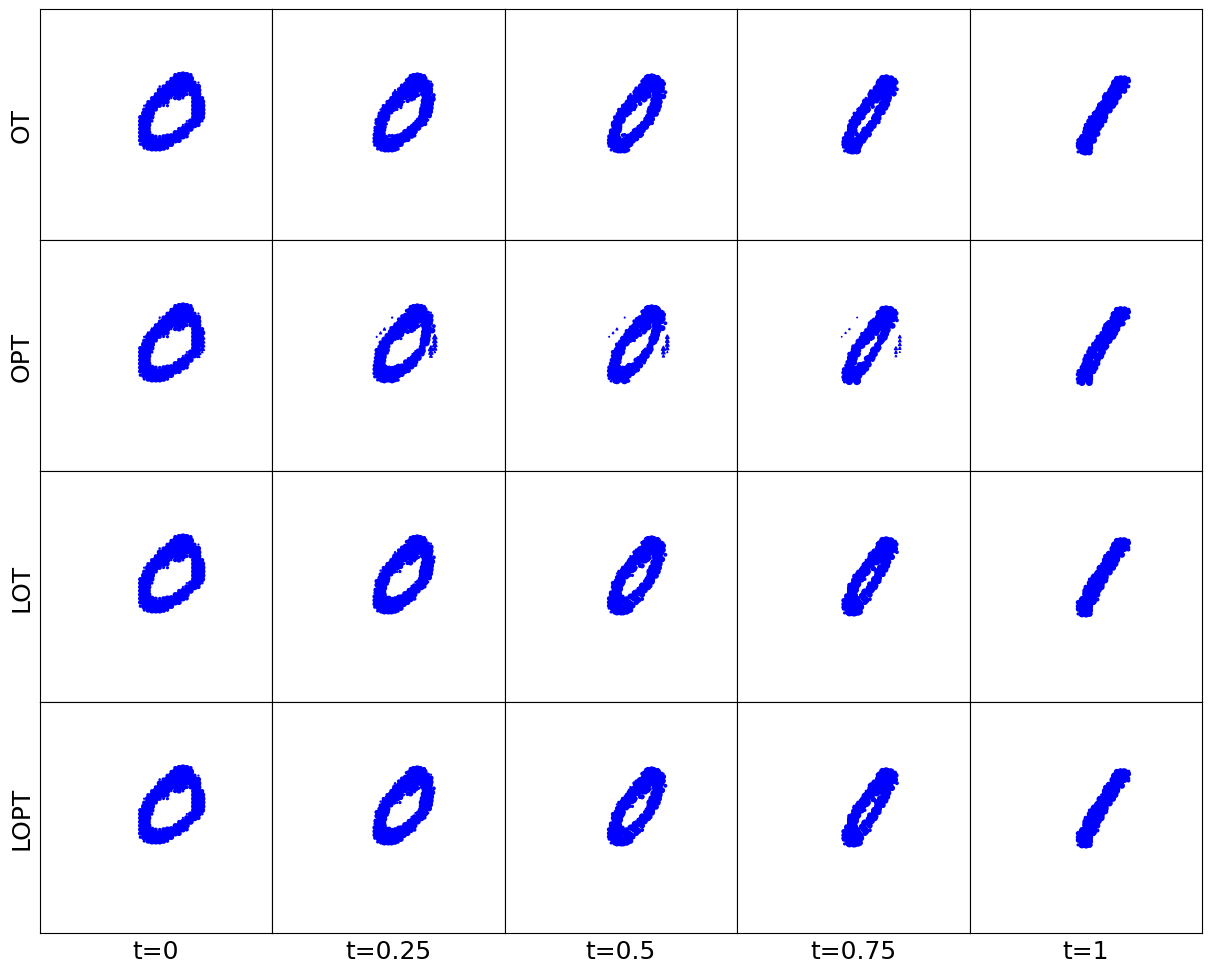

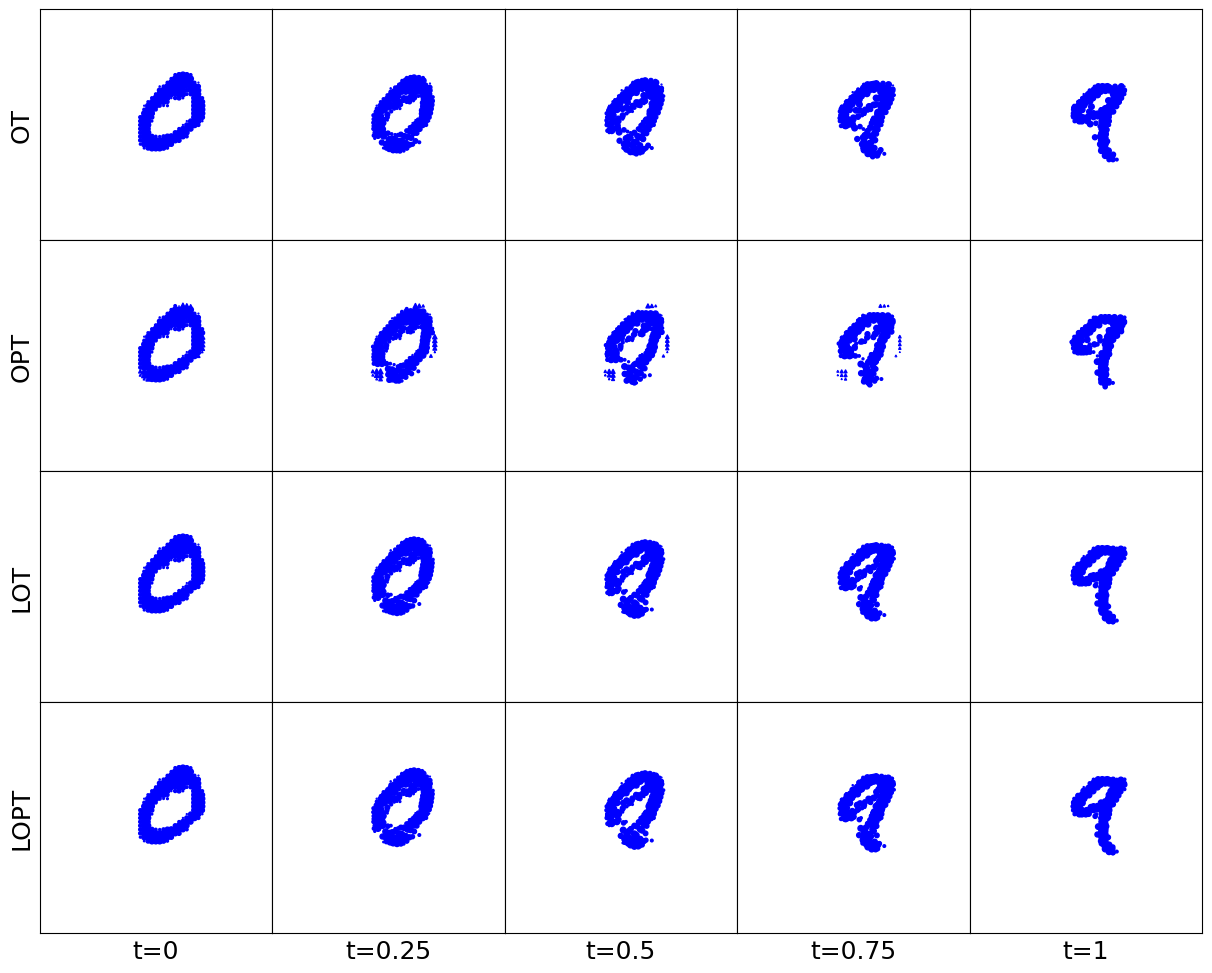

done


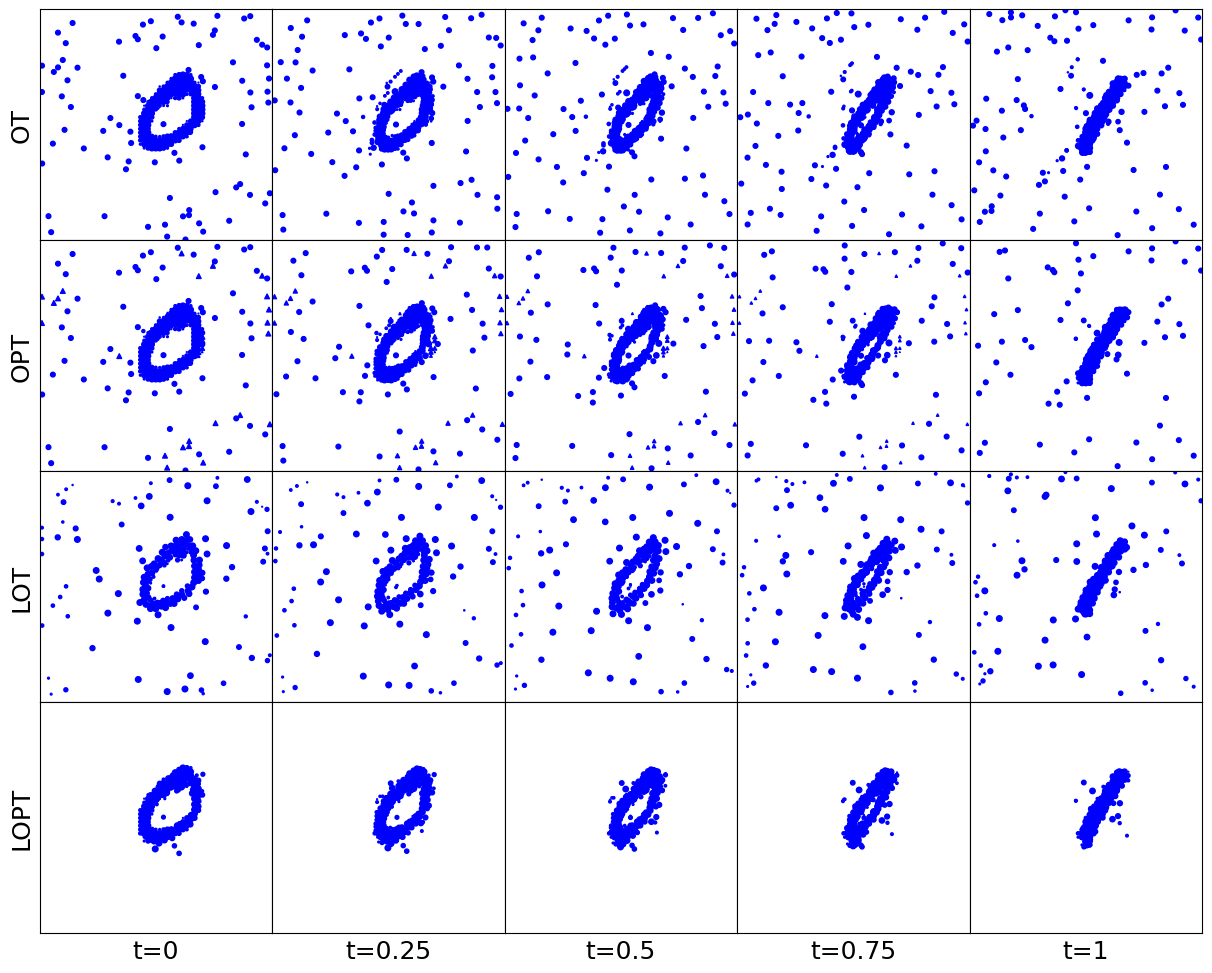

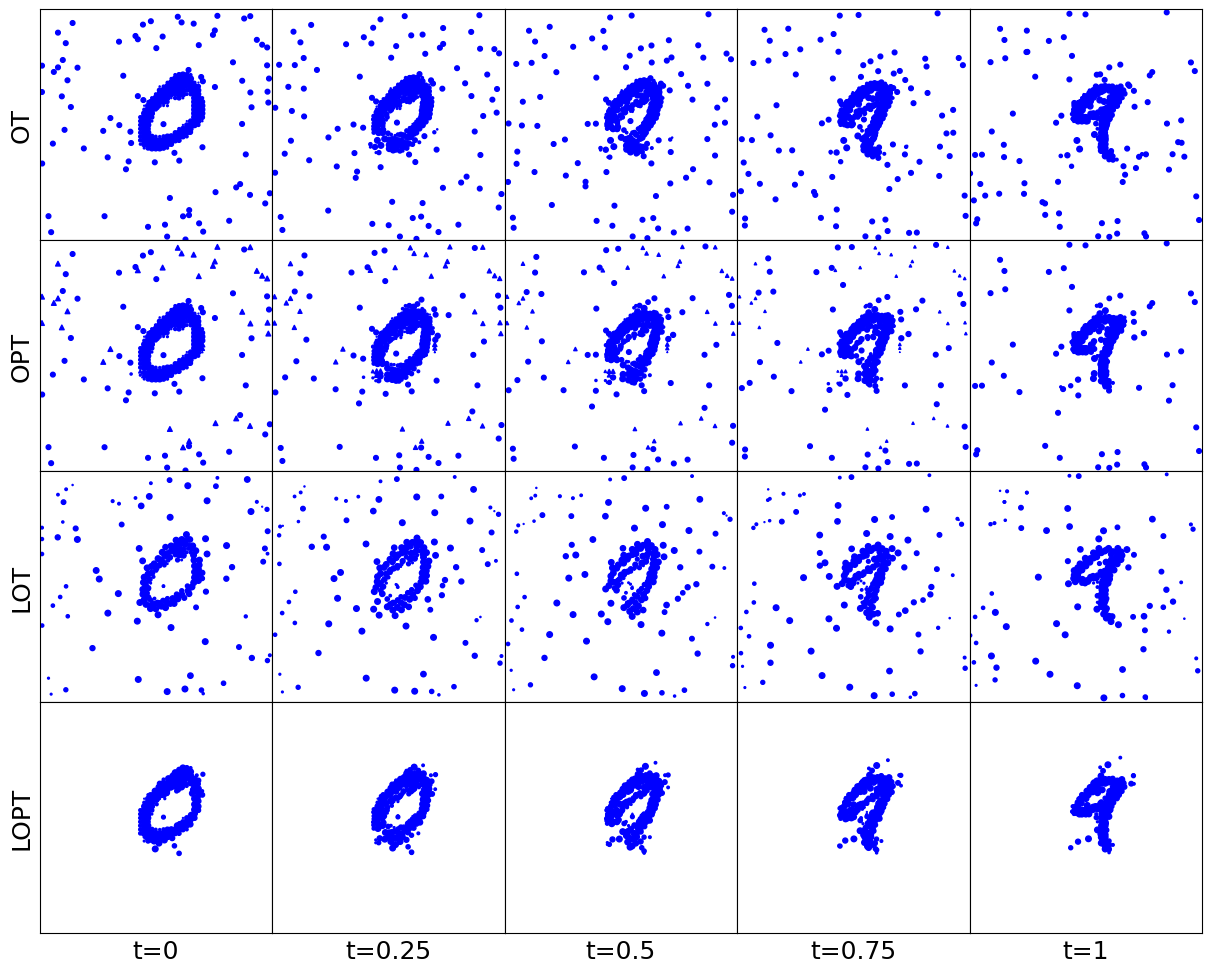

done


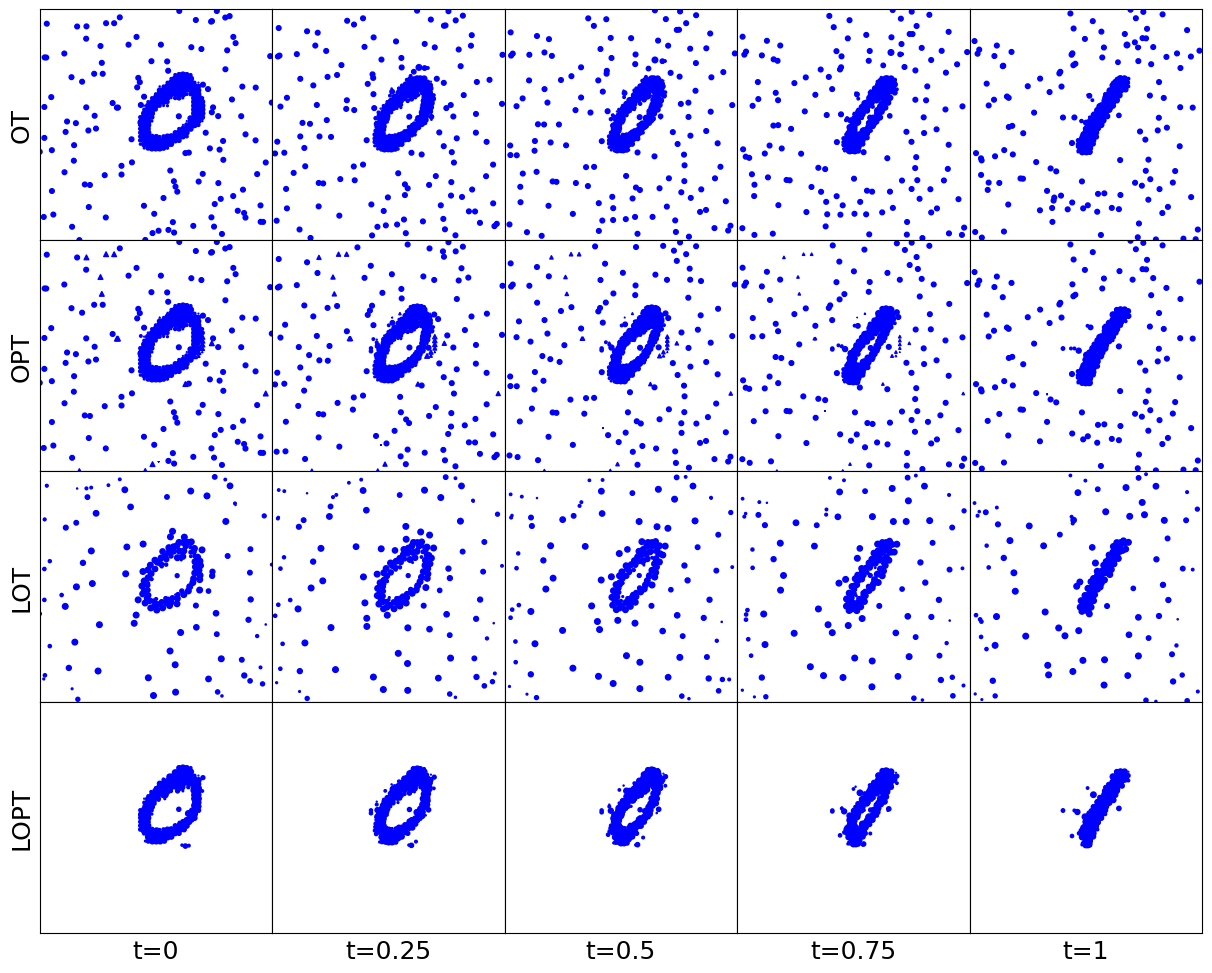

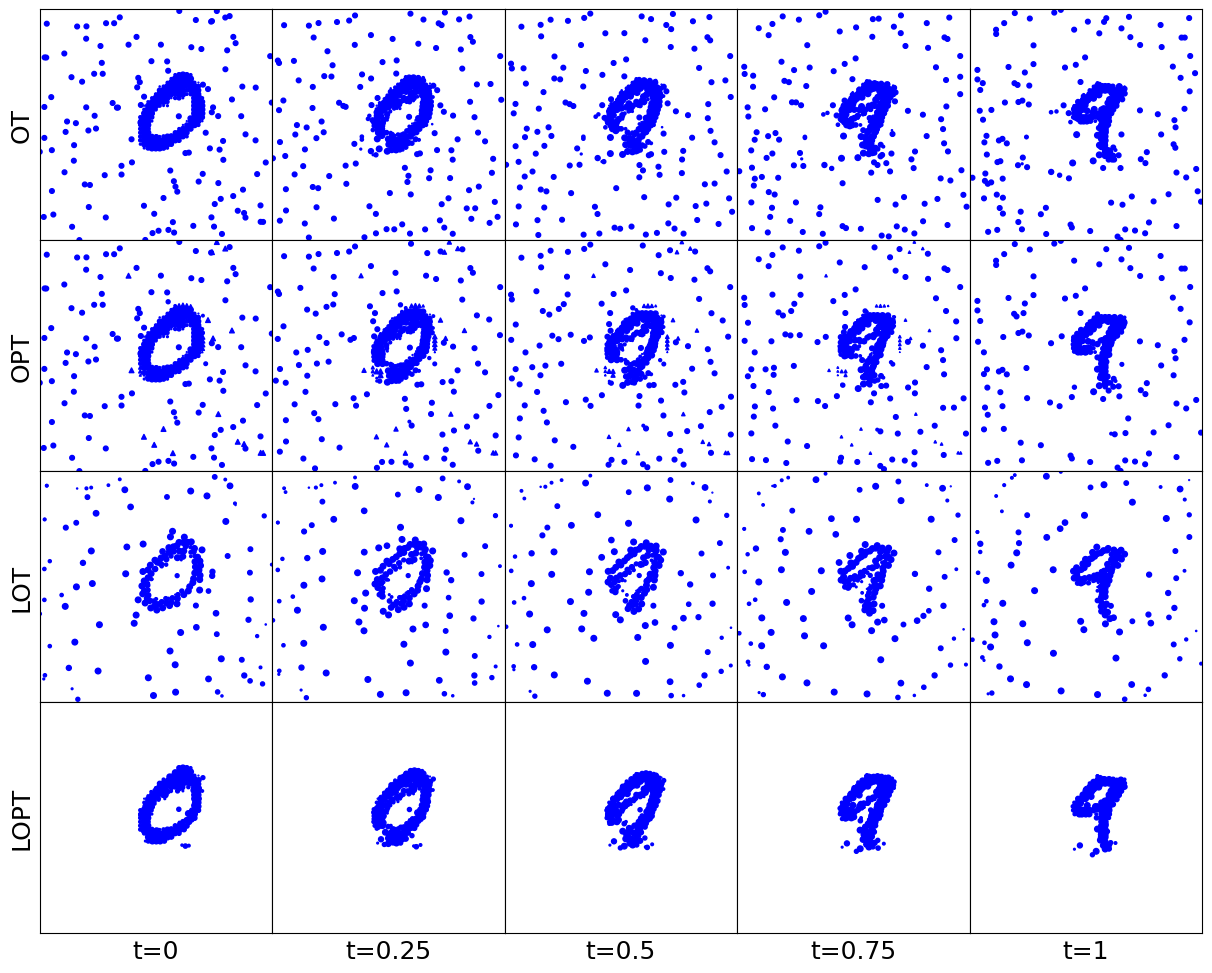

done


In [258]:
# plot the result
method_list=['ot','opt','lot','lopt']
result_path='experiment/geodesic/result/MNIST/'
label_list=['0','0.5','0.75']
ij_list=['01','02']
t_list=['0','0.25','0.5','0.75','1']
row_list=['t=0','t=0.25','t=0.5','t=0.75','t=1']
save_path='experiment/geodesic/result/MNIST'
xlim=[-20,40]
ylim=[-20,40]
for label in label_list:
    for ij in ij_list:
        fig,ax=plt.subplots(4,5,figsize=(3*5,3*4))
        name='geodesic_'+ij+'_'+label+'.pdf'
        for i in range(4):
            method=method_list[i]
            result_path=save_path+'/'+label+'_'+ij+'/'+method+'_result.pt'
            result=torch.load(result_path)            
            for j in range(5):                
                t=t_list[j]
                if method=='ot':
                    Xt,pt=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,xlim=xlim,ylim=ylim)
                elif method=='opt':
                    Xt,pt,X_d,p_d=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,X_d=X_d,p_d=p_d,xlim=xlim,ylim=ylim)
                elif method=='lot':
                    Xt,pt=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,xlim=xlim,ylim=ylim)
                elif method=='lopt':
                    Xt,pt,X_d,p_d,X_c,p_c=result[j]
                    scatter_2d_sub(ax[i,j],Xt,pt,X_d=X_d,p_d=p_d,X_c=X_c,p_c=p_c,xlim=xlim,ylim=ylim)
            
                
                # if j==0:
                #     ax[i,j].tick_params(left =False, right = False , labelleft = True ,
                #         labelbottom = False, bottom = False)
                # if i==3:
                #     ax[i,j].tick_params(left = False, right = False , labelleft = False ,
                #         labelbottom = True, bottom = False)

        for a, l in zip(ax[-1], row_list):
            a.set_xlabel(l,fontsize=18)

        for a, method in zip(ax[:,0], method_list):
            a.set_ylabel(method.upper() , rotation=90, fontsize=18)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(save_path+'/'+name,dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        
    print('done')
        